In [1]:
import numpy as np
import pandas as pd

# read pointcloud
point_cloud_data = np.loadtxt("sample.txt") # file name

# Check the size of the point cloud data
# The sample data should consist of six columns 
# including x, y, z, intensity, block type, and ring number
print(point_cloud_data.shape)

(1109768, 6)


In [2]:
points_xyz = point_cloud_data[:, :3]
intensity = point_cloud_data[:, 3]
segment = point_cloud_data[:, 4].astype(int)
ring = point_cloud_data[:, 5].astype(int)

df_point_cloud = pd.DataFrame({
    'x': points_xyz[:, 0],
    'y': points_xyz[:, 1],
    'z': points_xyz[:, 2],
    'intensity': intensity,
    'segment': segment,
    'ring': ring
})
df_point_cloud.head()

x         y         z  intensity  segment  ring
0 -2.511475 -4.519775 -1.281982    -1609.0        4     0
1 -2.510010 -4.528076 -1.289307    -1591.0        4     0
2 -2.502197 -4.524658 -1.292236    -1601.0        4     0
3 -2.506592 -4.522217 -1.292725    -1637.0        4     0
4 -2.507568 -4.512939 -1.291260    -1624.0        4     0

# Algorithm 1: Tunnel centre line extraction

## 1. Determine direction vector

In [3]:
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

# Obtain minimum bounding rectangle for the 2D XOY projection
points_2d_xoy = points_xyz[:, :2]
convex_hull = ConvexHull(points_2d_xoy)
convex_hull_points = points_2d_xoy[convex_hull.vertices]
convex_polygon = Polygon(convex_hull_points)
min_bounding_rect = convex_polygon.minimum_rotated_rectangle

# Get the four vertices of the minimum bounding rectangle
rect_vertices = np.array(min_bounding_rect.exterior.coords)[:-1]  # Drop the redundant last point

# Calculate the lengths of edges
edges = [np.linalg.norm(rect_vertices[i] - rect_vertices[(i + 1) % 4]) for i in range(4)]
short_edge_index = np.argmin(edges)

# Determine the centers of the two short sides
center1 = (rect_vertices[short_edge_index] + rect_vertices[(short_edge_index + 1) % 4]) / 2
center2 = (rect_vertices[(short_edge_index + 2) % 4] + rect_vertices[(short_edge_index + 3) % 4]) / 2

vector = center2 - center1
print(vector)

[ -1.58777022 -12.05179059]


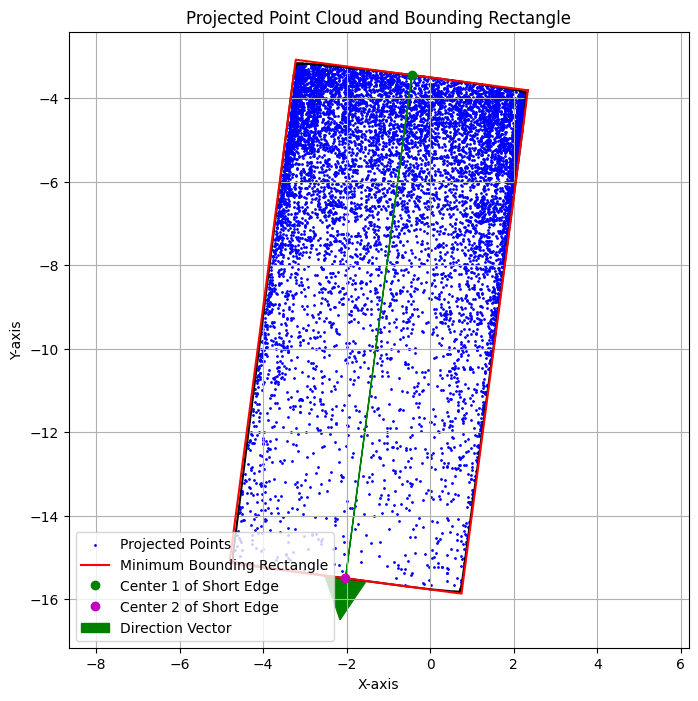

In [4]:
# if you want to visualize
#=========important: Ensure that the vector direction is consistent with the forward direction of the shield machine========= 
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(8, 8))

sample_size = 10000
indices = np.random.choice(len(points_2d_xoy), size=sample_size, replace=False)
sampled_points = points_2d_xoy[indices]

# Plot the original points
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], s=1, c='blue', label='Projected Points')

# Plot the convex hull
for simplex in convex_hull.simplices:
    plt.plot(points_2d_xoy[simplex, 0], points_2d_xoy[simplex, 1], 'k-')

# Plot the minimum bounding rectangle
rect_x, rect_y = zip(*(np.array(min_bounding_rect.exterior.coords)))
plt.plot(rect_x, rect_y, 'r-', label='Minimum Bounding Rectangle')

# Plot the centers of the short edges
plt.plot(center1[0], center1[1], 'go', label='Center 1 of Short Edge')
plt.plot(center2[0], center2[1], 'mo', label='Center 2 of Short Edge')

# Plot the vector as an arrow
plt.arrow(center1[0], center1[1], vector[0], vector[1], head_width=1, head_length=1, fc='green', ec='green', label='Direction Vector')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Projected Point Cloud and Bounding Rectangle')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

## 2. Generate point cloud slices

In [5]:
import numpy as np
import math
from tqdm.notebook import tqdm

def generate_slicing_planes_point_cloud(center1, center2, points_xyz, delta):
    """
    Generate slicing planes and point cloud slices along the line segment between two points.

    Parameters:
    center1 (array-like): Starting point of the line segment.
    center2 (array-like): Ending point of the line segment.
    points_xyz (numpy array): The point cloud data.
    delta (float): Half the thickness of slices.

    Returns:
    origin (list of numpy arrays): List of 3D coordinates for each plane.
    planes (list of numpy arrays): List of plane equations [A, B, C, D].
    slicing_cloud (list of lists of numpy arrays): List of sliced point clouds for each plane.
    """
    # Calculate the distance between center1 and center2 in the XY plane
    l = np.linalg.norm(center2[:2] - center1[:2])
    
    # Find the optimal integer n such that 1.2 * n is closest to l
    n = round(l / 1.2)
    min_diff = abs(l - 1.2 * n)
    optimal_n = n

    # Check nearby integer values for better match
    for candidate_n in [n - 1, n + 1]:
        diff = abs(l - 1.2 * candidate_n)
        if diff < min_diff:
            optimal_n = candidate_n
            min_diff = diff

    # Initialize lists to hold points and planes
    points_on_plane = []
    planes = []
    origin = []

    # Calculate direction vector and total distance
    direction = (center2 - center1) / np.linalg.norm(center2 - center1)
    total_distance = np.linalg.norm(center2 - center1)
    first_distance = total_distance / (2 * optimal_n)
    last_distance = total_distance - first_distance

    # Generate planes
    for i in range(optimal_n):
        if i == 0:
            segment_length = first_distance
        elif i == optimal_n - 1:
            segment_length = last_distance
        else:
            segment_length = first_distance + (i * (last_distance - first_distance)) / (optimal_n - 1)

        point_on_plane = center1 + (segment_length / total_distance) * (center2 - center1)
        points_on_plane.append(point_on_plane)
        origin.append(np.append(point_on_plane, 0))  # Convert to 3D by adding a zero z-component

        normal_vector = np.append(direction, 0)
        d = -np.dot(normal_vector[:2], point_on_plane)
        plane = np.append(normal_vector, d)
        planes.append(plane)

    # Initialize slicing cloud list
    slicing_cloud = []
    Delta = delta  # Half the thickness of slices

    points_xyz = np.asarray(points_xyz)  # Ensure points_xyz is a numpy array

    # Iterate over each plane with progress bar
    for plane in tqdm(planes, desc="Processing planes"):
        a, b, c, d = plane
        Wr = a * points_xyz[:, 0] + b * points_xyz[:, 1] + c * points_xyz[:, 2] + d - Delta
        Wl = a * points_xyz[:, 0] + b * points_xyz[:, 1] + c * points_xyz[:, 2] + d + Delta
        mask = (Wr * Wl <= 0)
        slicing_cloud.append(points_xyz[mask])

    return origin, planes, slicing_cloud


In [6]:
delta = 0.005  # Thickness of slices / 2

origin, planes, slicing_cloud = generate_slicing_planes_point_cloud(center1, center2, points_xyz, delta)
print(f"Number of sliced clouds: {len(slicing_cloud)}")
ring_count = len(slicing_cloud)

Processing planes:   0%|          | 0/10 [00:00<?, ?it/s]

Number of sliced clouds: 10


## 3. Ellipse centre fitting of Cloud<sub>Slices</sub>

In [7]:
import numpy as np

def project_to_plane(point_cloud, center, normal):
    '''
    Project a 3D point cloud onto a known plane, and convert the projected points to 2D coordinates.
    The origin (0, 0) in 2D corresponds to the `center` point in 3D.

    Args:
        point_cloud: numpy array, shape (N, 3). Represents a 3D point cloud.
        center: numpy array, shape (3,). Represents a point on the plane, which will be the origin in the 2D projection.
        normal: numpy array, shape (3,). Represents the normal vector of the plane.

    Returns:
        numpy array, shape (N, 2). Represents the 2D coordinates of the projected points on the plane.
    '''
    
    # Move the center of the point cloud to the origin.
    shifted_point_cloud = np.array(point_cloud) - np.array(center)
    
    # Compute the projection of the point cloud onto the plane's normal vector.
    projection = np.dot(shifted_point_cloud, normal)
    
    # Compute the coordinates of the projected points onto the plane.
    projected_points = shifted_point_cloud - np.outer(projection, normal)
    
    # Define the 2D coordinate system on the plane:
    x_axis = np.array([-normal[1], normal[0], 0])
    x_axis /= np.linalg.norm(x_axis)

    # y-axis is orthogonal to both the normal and x_axis.
    y_axis = np.cross(normal, x_axis)

    # Calculate the 2D coordinates by projecting the 3D points onto the x and y axes.
    x_coords = np.dot(projected_points, x_axis)
    y_coords = np.dot(projected_points, y_axis)
    
    return np.vstack((x_coords, y_coords)).T


In [8]:
# Define the normal vector and center for projection
normal = np.array([planes[0][0], planes[0][1], 0])

# Project each point in slicing_cloud onto the plane
point2ds = []
for i in range(len(origin)):
    point2ds_temp = project_to_plane(slicing_cloud[i], origin[i], normal)
    point2ds.append(point2ds_temp)

# Process each set of 2D points
filtered_point2ds = []
for points in point2ds:
    # Find the maximum y-coordinate
    y_max = max(point[1] for point in points)
    # Filter points where y-coordinate is within 4.5 units of y_max
    filtered_points = [point for point in points if abs(point[1] - y_max) <= 4.5]
    filtered_point2ds.append(filtered_points)

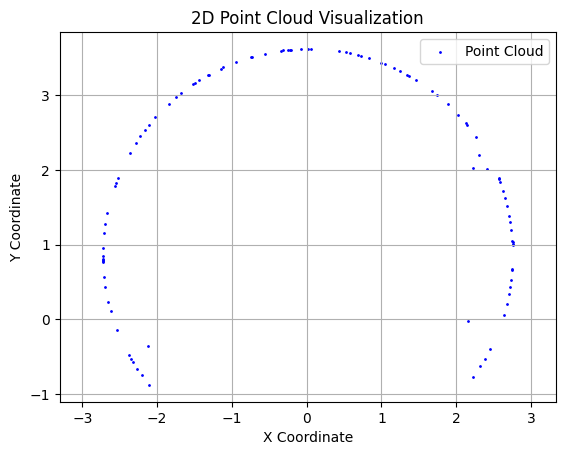

In [9]:
# if you want to visulize
import matplotlib.pyplot as plt

x_coords = [point[0] for point in filtered_point2ds[8]]
y_coords = [point[1] for point in filtered_point2ds[8]]

plt.scatter(x_coords, y_coords, c='blue', s=1, marker='o', label='Point Cloud')

plt.title('2D Point Cloud Visualization')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

In [10]:
import cv2
import random
import time

class RANSAC:
    def __init__(self, data, threshold, P, S, N):
        self.point_data = data  # Ellipse contour points
        self.error_threshold = threshold  # Error tolerance threshold
        self.N = N  # Number of points to sample
        self.S = S  # Inlier ratio
        self.P = P  # Probability of finding a correct model
        self.max_inliers = len(data) * S  # Maximum number of inliers
        self.items = 999  # Number of iterations
        self.count = 0  # Number of inliers
        self.best_model = ((0, 0), (1e-6, 1e-6), 0)  # Best ellipse model

    def random_sampling(self, n):
        """Randomly select n data points."""
        return np.asarray(random.sample(list(self.point_data), n))

    def Geometric2Conic(self, ellipse):
        """Convert ellipse parameters to conic coefficients."""
        (x0, y0), (bb, aa), phi_b_deg = ellipse
        a, b = aa / 2, bb / 2  # Semi-major and semi-minor axes
        phi_b_rad = np.radians(phi_b_deg)  # Convert angle to radians
        ax, ay = -np.sin(phi_b_rad), np.cos(phi_b_rad)  # Major axis unit vector

        # Conic parameters
        a2, b2 = a * a, b * b
        if a2 > 0 and b2 > 0:
            A = ax * ax / a2 + ay * ay / b2
            B = 2 * ax * ay / a2 - 2 * ax * ay / b2
            C = ay * ay / a2 + ax * ax / b2
            D = (-2 * ax * ay * y0 - 2 * ax * ax * x0) / a2 + (2 * ax * ay * y0 - 2 * ay * ay * x0) / b2
            E = (-2 * ax * ay * x0 - 2 * ay * ay * y0) / a2 + (2 * ax * ay * x0 - 2 * ax * ax * y0) / b2
            F = (2 * ax * ay * x0 * y0 + ax * ax * x0 * x0 + ay * ay * y0 * y0) / a2 + \
                (-2 * ax * ay * x0 * y0 + ay * ay * x0 * x0 + ax * ax * y0 * y0) / b2 - 1
        else:
            A, B, C, D, E, F = 1, 0, 1, 0, 0, -1e-6  # Default for degenerate cases

        return np.array([A, B, C, D, E, F])

    def eval_model(self, ellipse):
        """Evaluate the ellipse model and count inliers."""
        a, b, c, d, e, f = self.Geometric2Conic(ellipse)
        E = 4 * a * c - b * b
        if E <= 0:
            return 0, np.array([])  # Not an ellipse

        (x, y), (LAxis, SAxis), Angle = ellipse
        LAxis, SAxis = LAxis / 2, SAxis / 2
        if SAxis > LAxis:
            SAxis, LAxis = LAxis, SAxis  # Ensure LAxis is the longer one

        # Calculate foci
        Axis = math.sqrt(LAxis**2 - SAxis**2)
        f1_x = x - Axis * math.cos(math.radians(Angle))
        f1_y = y - Axis * math.sin(math.radians(Angle))
        f2_x = x + Axis * math.cos(math.radians(Angle))
        f2_y = y + Axis * math.sin(math.radians(Angle))

        # Compute distances to foci
        f1, f2 = np.array([f1_x, f1_y]), np.array([f2_x, f2_y])
        f1_distance = np.sum((self.point_data - f1)**2, axis=1)
        f2_distance = np.sum((self.point_data - f2)**2, axis=1)
        all_distance = np.sqrt(f1_distance) + np.sqrt(f2_distance)

        # Identify inliers
        Z = np.abs(2 * LAxis - all_distance)
        delta = np.sqrt(np.mean((Z - np.mean(Z))**2))
        inliers = np.where(Z < 0.8 * delta)[0]
        inlier_points = self.point_data[inliers]

        return len(inlier_points), inlier_points

    def execute_ransac(self):
        """Run RANSAC algorithm to fit an ellipse."""
        start_time = time.time()
        while math.ceil(self.items):
            # Randomly sample N points
            select_points = self.random_sampling(self.N)
            select_points_list = [(point[0], point[1]) for point in select_points]

            # Fit an ellipse to the selected points
            ellipse = cv2.fitEllipse(np.array(select_points_list, dtype=np.float32))

            # Evaluate the model and find inliers
            inliers_count, inliers_set = self.eval_model(ellipse)
            inliers_set = np.array([tuple(point) for point in inliers_set], dtype=np.float32)

            # Update the best model if current inliers are better
            if inliers_count > self.count:
                self.count = inliers_count
                self.best_model = cv2.fitEllipse(inliers_set)  # Fit ellipse on inliers

                # Check if we have reached the expected number of inliers
                if self.count > self.max_inliers:
                    print('Inlier ratio: ', self.count / len(self.point_data))
                    break

                # Update number of iterations
                self.items = math.log(1 - self.P) / math.log(1 - (inliers_count / len(self.point_data))**self.N)

        return self.best_model, inliers_set


In [11]:
# Initialize lists to store ellipse centers
X_center = []
Y_center = []

LAxis_sets = []
SAxis_sets = []
Angle_sets = []
in_sets = []

for i in range(len(slicing_cloud)):
    # Prepare point data for RANSAC
    points_data = np.reshape(filtered_point2ds[i], (-1, 2))  # Ellipse edge points

    # First RANSAC fit to find initial inliers
    ransac = RANSAC(data=points_data, threshold=1.0, P=0.9, S=0.75, N=5)
    # _, inliers_set = ransac.execute_ransac()
    _, inliers_set = ransac.execute_ransac()
    

    # Refine fit using inliers from the first RANSAC
    points_data = np.reshape(inliers_set, (-1, 2))
    ransac = RANSAC(data=points_data, threshold=1.0, P=0.9, S=0.75, N=5)
    ellipse_params, _ = ransac.execute_ransac()

    # Extract center coordinates
    # ((X, Y), _, _) = ellipse_params
    ((X, Y), (LAxis, SAxis), Angle) = ellipse_params

    X_center.append(X)
    Y_center.append(Y)

    LAxis_sets.append(LAxis)
    SAxis_sets.append(SAxis)
    Angle_sets.append(Angle)
    in_sets.append(inliers_set)

print('done')

Inlier ratio:  0.9198064293121327
Inlier ratio:  0.7655016910935738
Inlier ratio:  0.8085889570552147
Inlier ratio:  0.8679817905918058
Inlier ratio:  0.9180161943319838
Inlier ratio:  0.7618522601984564
Inlier ratio:  0.9266666666666666
Inlier ratio:  0.8776978417266187
Inlier ratio:  0.9436274509803921
Inlier ratio:  0.8181818181818182
Inlier ratio:  0.9366666666666666
Inlier ratio:  0.8790035587188612
Inlier ratio:  0.9356435643564357
Inlier ratio:  0.7671957671957672
Inlier ratio:  0.9151515151515152
Inlier ratio:  0.7880794701986755
Inlier ratio:  0.95
Inlier ratio:  0.7684210526315789
Inlier ratio:  0.9051724137931034
Inlier ratio:  0.7523809523809524
done


Ellipse(xy=(0.017114542424678802, 0.8686749935150146), width=5.486191272735596, height=5.501618385314941, angle=178.27366638183594)


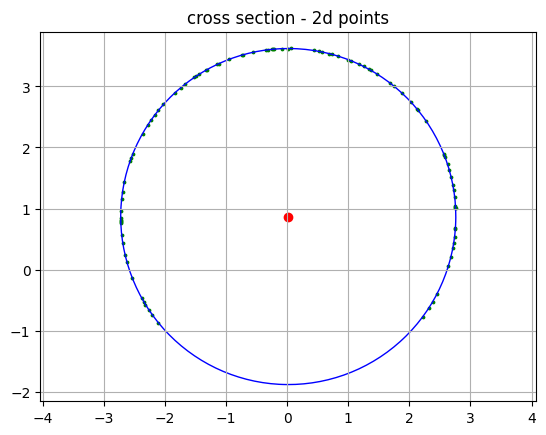

In [12]:
# if you want to check fitting results
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
i = 8
ip1 = in_sets[i][:,0]
ip2 = in_sets[i][:,1]

ellipse = Ellipse(xy=(X_center[i],Y_center[i]), width=LAxis_sets[i], height=SAxis_sets[i], angle=Angle_sets[i], edgecolor='b', fc='None')
print(ellipse)
plt.figure('Draw')
plt.scatter(ip1,ip2,s=3,color='green')
plt.scatter(X_center[i],Y_center[i],color='red')
plt.gca().add_patch(ellipse)
plt.axis('equal')
plt.title('cross section - 2d points')
plt.grid(True)
plt.draw()

In [13]:
def get_3dcoordinates_from_plane(point2d,plane_params,origin):
    """
    Computes the coordinates of a point in 3D space given its coordinates in the plane coordinate system.
    
    Args:
        point2d: numpy array, shape (2,). Represents 2D points in the plane.
        plane_params: numpy array, shape (4,). Represents the parameters of the known plane.
        origin: numpy array, shape (3,). Represents the 3D coordinates of the origin of the known plane.

    Returns:
        numpy array, shape (N, 3). Represents the 3D coordinates of the 2D points.
    """
    xp,yp = point2d
    A,B,C,D = plane_params
    x0,y0,z0 = origin
    
    # normal vector of the plane
    N = np.array([A, B, C])
    N = N / np.linalg.norm(N)
    
    # calculate vector V, which is the x-axis of the 2D coordinate system
    Vx = -B
    Vy = A
    Vz = 0
    V = np.array([Vx, Vy, Vz])
    V = V / np.linalg.norm(V)
    
    # calculate vector U, which is the y-axis of the 2D coordinate system
    U = np.cross(N, V)
    U = U / np.linalg.norm(U)
    
    # calculate 3D coordinates
    x = x0+xp*V[0]+yp*U[0]
    y = y0+xp*V[1]+yp*U[1]
    z = z0+xp*V[2]+yp*U[2]
    
    return [x,y,z]

In [14]:
# Initialize list to store 3D coordinates
cps = []

# Compute 3D coordinates for each center point
for i in range(len(slicing_cloud)):
    point2d_cp = np.array([X_center[i], Y_center[i]])
    cp = get_3dcoordinates_from_plane(point2d_cp, planes[i], origin[i])
    cps.append(cp)

# Construct final list of coordinates
cps_arr= np.array(cps)

len(cps_arr) # should be same to len(slicing_cloud)

10

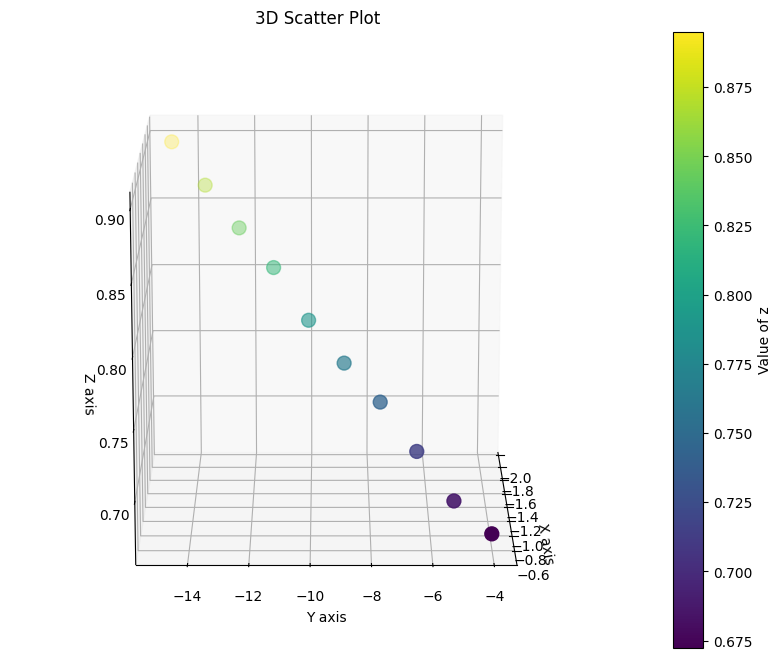

In [15]:
# 3D visualization
from mpl_toolkits.mplot3d import Axes3D

x = cps_arr[:, 0]
y = cps_arr[:, 1]
z = cps_arr[:, 2]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=100)

cbar = plt.colorbar(sc)
cbar.set_label('Value of z')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot')

ax.view_init(elev=15, azim=0)
ax.set_aspect('auto')
ax.set_box_aspect([1,1,1])
plt.show()


## 4. 3D Curve Curve<sub>centre</sub> fitting

X parameters: [-5.19634136e-01 -1.54290329e-01 -3.28290491e-04  5.42412213e-06]
Y parameters: [-4.04809955e+00 -1.20577016e+00  4.32508232e-05 -7.14604150e-07]
Z parameters: [ 6.70593704e-01  2.03135702e-02  1.08942605e-03 -6.48059952e-05]


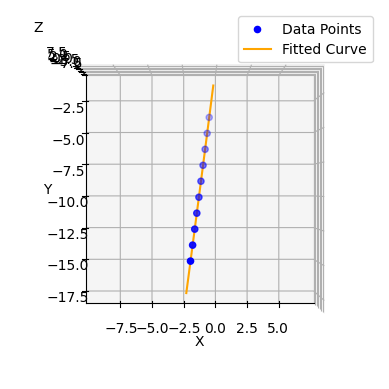

In [16]:
import numpy as np
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate parameter t for each point (using indices as parameter t)
t = np.arange(ring_count)

# Polynomial feature expansion, degree 2
degree = 3
poly = PolynomialFeatures(degree)

# Polynomial feature transformation for x(t), y(t), z(t)
t_poly = poly.fit_transform(t.reshape(-1, 1))
x_poly = t_poly
y_poly = t_poly
z_poly = t_poly

# Initialize RANSAC Regressor for x, y, z
ransac_x = RANSACRegressor()
ransac_y = RANSACRegressor()
ransac_z = RANSACRegressor()

# Fit the RANSAC model to x, y, z coordinates
ransac_x.fit(x_poly, cps_arr[:, 0])
ransac_y.fit(y_poly, cps_arr[:, 1])
ransac_z.fit(z_poly, cps_arr[:, 2])

# Get polynomial coefficients and intercepts
x_coef = ransac_x.estimator_.coef_
y_coef = ransac_y.estimator_.coef_
z_coef = ransac_z.estimator_.coef_
x_intercept = ransac_x.estimator_.intercept_
y_intercept = ransac_y.estimator_.intercept_
z_intercept = ransac_z.estimator_.intercept_

# Adjust coefficients to include the intercept term
x_params = x_coef.copy()
x_params[0] = x_intercept

y_params = y_coef.copy()
y_params[0] = y_intercept

z_params = z_coef.copy()
z_params[0] = z_intercept

# Print the coefficients for x, y, z
print("X parameters:", x_params)
print("Y parameters:", y_params)
print("Z parameters:", z_params)

# Extend t range for plotting
t_extend = np.linspace(-2, ring_count+1, 100)
t_extend_poly = poly.transform(t_extend.reshape(-1, 1))

# Predict fitted values for extended t range
x_fit_extend = ransac_x.predict(t_extend_poly)
y_fit_extend = ransac_y.predict(t_extend_poly)
z_fit_extend = ransac_z.predict(t_extend_poly)

# Plot the fitted curve and original data points in 3D

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the original data points and the fitted curve
ax.scatter(cps_arr[:, 0], cps_arr[:, 1], cps_arr[:, 2], color='blue', label='Data Points')
ax.plot(x_fit_extend, y_fit_extend, z_fit_extend, color='orange', label='Fitted Curve')

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Set view angle
ax.view_init(elev=90, azim=-90)  # Elevation 90°, Azimuth -90°, for counterclockwise rotation

# Get the limits of x, y, z axes
xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

# Manually adjust the ranges of x, y, z to make the scales equal
max_range = np.array([xlim[1] - xlim[0], ylim[1] - ylim[0], zlim[1] - zlim[0]]).max()
mid_x = np.mean(xlim)
mid_y = np.mean(ylim)
mid_z = np.mean(zlim)

ax.set_xlim(mid_x - max_range / 2, mid_x + max_range / 2)
ax.set_ylim(mid_y - max_range / 2, mid_y + max_range / 2)
ax.set_zlim(mid_z - max_range / 2, mid_z + max_range / 2)

plt.show()

In [17]:
import numpy as np
from numba import njit, prange
import faiss
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import time

@njit
def poly_eval(coeffs, x):
    result = 0.0
    for coeff in coeffs:
        result = result * x + coeff
    return result

@njit(parallel=True)
def curve_func(t, x_params, y_params, z_params):
    result = np.empty((len(t), 3))
    for i in prange(len(t)):
        result[i, 0] = poly_eval(x_params[::-1], t[i])
        result[i, 1] = poly_eval(y_params[::-1], t[i])
        result[i, 2] = poly_eval(z_params[::-1], t[i])
    return result

@njit
def poly_deriv(coeffs):
    return np.array([i * c for i, c in enumerate(coeffs[:0:-1])][::-1])

@njit(parallel=True)
def curve_deriv(t, x_params, y_params, z_params):
    result = np.empty((len(t), 3))
    dx_params = poly_deriv(x_params[::-1])
    dy_params = poly_deriv(y_params[::-1])
    dz_params = poly_deriv(z_params[::-1])
    for i in prange(len(t)):
        result[i, 0] = poly_eval(dx_params, t[i])
        result[i, 1] = poly_eval(dy_params, t[i])
        result[i, 2] = poly_eval(dz_params, t[i])
    return result
    
@njit
def calculate_angle_with_direction(A, B, C):
    ''' 
    A is point from point cloud, 
    B is the closest point of A on the curve, 
    Angle ABC is angle value of point A in cylindrical coordinates
    '''
    AB = B - A
    BC = C - B
    
    dot_product = np.dot(AB, BC)
    norm_AB = np.sqrt(np.dot(AB, AB))
    norm_BC = np.sqrt(np.dot(BC, BC))
    
    if norm_AB == 0 or norm_BC == 0:
        return 0.0, np.linalg.norm(AB)
    
    cos_angle = dot_product / (norm_AB * norm_BC)
    angle_radians = np.arccos(cos_angle)
    angle_degrees = angle_radians * (180.0 / np.pi)
    cross_product = np.cross(AB, BC)
    if cross_product[2] < 0:
        angle_degrees = 360 - angle_degrees

    return angle_degrees, np.linalg.norm(AB)

@njit
def compute_C_points_and_arc_length(B_points, T_vectors, arc_lengths):
    C_points = np.empty_like(B_points)
    for i in range(B_points.shape[0]):
        B = B_points[i]
        T = T_vectors[i]
        lambda_ = -T[2] / (T[0]**2 + T[1]**2)
        C = B + lambda_ * np.array([T[0], T[1], 0]) + np.array([0, 0, 1])
        C_points[i] = C

        # Compute arc length
        if i > 0:
            prev_B = B_points[i-1]
            arc_lengths[i] = arc_lengths[i-1] + np.linalg.norm(B - prev_B)
        else:
            arc_lengths[i] = 0.0
    
    return C_points, arc_lengths

# Precompute the curve points, derivatives, C_points, and arc lengths based on B_points
num_samples = ring_count * 1210 # around 1mm accuracy
t_samples = np.linspace(-20, ring_count + 20, num_samples)
B_points = curve_func(t_samples, x_params, y_params, z_params)
T_vectors = curve_deriv(t_samples, x_params, y_params, z_params)
arc_lengths = np.zeros(num_samples, dtype=np.float32)

C_points, arc_lengths = compute_C_points_and_arc_length(B_points, T_vectors, arc_lengths)

# Build Faiss index
index = faiss.IndexFlatL2(3)
index.add(B_points)

start_time = time.time()

# Define batch size for Faiss search to improve performance
batch_size = 1000000  # Adjust batch size based on memory constraints

def process_batch(points_batch):
    ''' Process a batch of points to find nearest neighbors, angles, and distances '''
    _, idx_batch = index.search(points_batch, 1)
    results = []
    
    for i in range(points_batch.shape[0]):
        A = points_batch[i]
        idx = idx_batch[i][0]
        B = B_points[idx]
        C = C_points[idx]
        angle_ABC, distance_AB = calculate_angle_with_direction(A, B, C)
        arc_length_B = arc_lengths[idx]
        results.append((distance_AB, angle_ABC, arc_length_B))
    
    return results

# Split points into batches for parallel processing
num_batches = (len(points_xyz) + batch_size - 1) // batch_size
points_batches = np.array_split(points_xyz, num_batches)

# Using Joblib for parallel batch processing
cylindrical_coords_batches = Parallel(n_jobs=12)(
    delayed(process_batch)(batch) for batch in tqdm(points_batches, desc="Calculating cylindrical coordinates", total=len(points_batches))
)

cylindrical_coords = []
for batch_result in cylindrical_coords_batches:
    cylindrical_coords.extend(batch_result)

end_time = time.time()

print(f"Total computation time: {end_time - start_time:.6f} seconds")

Calculating cylindrical coordinates:   0%|          | 0/2 [00:00<?, ?it/s]

Total computation time: 5.897602 seconds


In [18]:
# recording data
import pandas as pd

diameter = 5.5
df_point_cloud['r'] = np.array(cylindrical_coords)[:,0]
df_point_cloud['theta'] = np.array(cylindrical_coords)[:,1]* (np.pi*diameter / 360)
df_point_cloud['h'] = np.array(cylindrical_coords)[:,2]
df_point_cloud.head()

x         y         z  intensity  segment  ring         r     theta  \
0 -2.511475 -4.519775 -1.281982    -1609.0        4     0  2.744104  2.125163   
1 -2.510010 -4.528076 -1.289307    -1591.0        4     0  2.747706  2.118148   
2 -2.502197 -4.524658 -1.292236    -1601.0        4     0  2.744669  2.110898   
3 -2.506592 -4.522217 -1.292725    -1637.0        4     0  2.748242  2.113945   
4 -2.507568 -4.512939 -1.291260    -1624.0        4     0  2.748568  2.116620   

           h  
0  25.015549  
1  25.025597  
2  25.020573  
3  25.020573  
4  25.010525

In [19]:
df_point_cloud.to_csv('sample_unwrapped.csv',index=False)

# Algorithm 2: Local point cloud density-difference-based denoising

In [20]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm
from scipy.ndimage import uniform_filter1d
from numba import njit, prange
import time

# Start the timer
start_time = time.time()

# Add a 'pred' column and initialize to 7
df_point_cloud['pred'] = 7

# Initial filter based on 'r' column
mask_r = (df_point_cloud['r'] < 2.7)|(df_point_cloud['r'] > 2.8) # diameter is 5.5
df_point_cloud.loc[mask_r, 'pred'] = 0

# Remaining point cloud data
filtered_df = df_point_cloud[~mask_r].copy()

# Define bins for X, Y, and Z directions
x_points = filtered_df['h'].values
y_points = filtered_df['theta'].values
z_points = filtered_df['r'].values

min_x, max_x = np.min(x_points), np.max(x_points)
min_y, max_y = np.min(y_points), np.max(y_points)
min_z, max_z = np.min(z_points), np.max(z_points)

print('Range of X:', '[', min_x, max_x, ']')

# Set grid sizes
x_step = (max_x - min_x) / ring_count
y_step = 0.5
z_step = 0.001

x_bins = np.arange(min_x, max_x + x_step, x_step)
y_bins = np.arange(min_y, max_y + y_step, y_step)
z_bins = np.arange(min_z, max_z + z_step, z_step)

# Initialize list to store filtered points and count matrices
filtered_points_list = []
count_matrices = []

# Pre-compute useful variables
grad_threshold = 0.2
epsilon = 1e-6

@njit(parallel=True)
def calculate_counts_matrix(y_points_sub, z_points_sub, y_bins, z_bins):
    counts_matrix = np.zeros((len(y_bins) - 1, len(z_bins) - 1))
    for i in prange(len(y_bins) - 1):
        y_min, y_max = y_bins[i], y_bins[i + 1]
        for j in range(len(z_bins) - 1):
            z_min, z_max = z_bins[j], z_bins[j + 1]
            mask = (y_points_sub >= y_min) & (y_points_sub < y_max) & (z_points_sub >= z_min) & (z_points_sub < z_max)
            counts_matrix[i, j] = np.sum(mask)
    return counts_matrix

@njit(parallel=True)
def calculate_cutoff_z_values(counts_matrix, z_bins, grad_threshold, epsilon):
    cutoff_z_values = np.full(counts_matrix.shape[0], 2.7)
    max_z_temp_values = np.zeros(counts_matrix.shape[0])
    
    for i in prange(counts_matrix.shape[0]):
        counts = counts_matrix[i, :]
        
        if np.all(counts == 0):
            continue
        
        max_count_idx = np.argmax(counts)
        grad_counts = np.diff(counts) / (counts[:-1] + epsilon)
        
        max_z_temp_values[i] = z_bins[max_count_idx]
        
        last_non_zero_idx = max_count_idx
        for j in range(max_count_idx, 0, -1):
            if counts[j] != 0:
                last_non_zero_idx = j
                
            if grad_counts[j - 1] < -grad_threshold or (counts[j] == 0 and counts[j - 1] == 0):
                cutoff_z_values[i] = z_bins[last_non_zero_idx]
                break
                
    return cutoff_z_values, max_z_temp_values

# Initialize list to store filtered points and count matrices
filtered_points_list = []
count_matrices = []

# Iterate over X bins
for x_min in x_bins[:-1]:
    x_max = x_min + x_step
    print('x_min-x_max:','[',x_min,x_max,']')
    mask_x = (x_points >= x_min) & (x_points < x_max)
    y_points_sub = y_points[mask_x]
    z_points_sub = z_points[mask_x]

    # Calculate count matrix using numba
    counts_matrix = calculate_counts_matrix(y_points_sub, z_points_sub, y_bins, z_bins)
    count_matrices.append(counts_matrix)

    # Calculate cutoff values using numba
    cutoff_z_values, max_z_temp_values = calculate_cutoff_z_values(counts_matrix, z_bins, grad_threshold, epsilon)

    # Handle NaNs and smoothing
    nan_indices = np.isnan(cutoff_z_values)
    not_nan_indices = ~nan_indices

    if np.any(nan_indices):
        interp_func = interp1d(
            np.where(not_nan_indices)[0],
            cutoff_z_values[not_nan_indices],
            kind='linear',
            fill_value='extrapolate'
        )
        cutoff_z_values[nan_indices] = interp_func(np.where(nan_indices)[0])

    cutoff_z_values_smoothed = uniform_filter1d(cutoff_z_values, size=3, mode='nearest') - 0.003

    index_ranges = [[min_y + i * y_step, min_y + (i + 1) * y_step] for i in range(len(cutoff_z_values))]
    df_visual = pd.DataFrame({
        'Y range': index_ranges,
        'cutoff_z': cutoff_z_values,
        'smoothed_z': cutoff_z_values_smoothed,
        'max_z': max_z_temp_values
    })
    df_visual['Y range'] = df_visual['Y range'].apply(lambda x: [round(val, 4) for val in x])
    print(df_visual)

    # Vectorized filtering based on cutoff values
    y_indices = np.digitize(y_points_sub, y_bins) - 1
    filtered_mask = (z_points_sub >= cutoff_z_values_smoothed[y_indices])
    
    filtered_points_sub = {
        'h': x_points[mask_x][filtered_mask],
        'theta': y_points[mask_x][filtered_mask],
        'r': z_points[mask_x][filtered_mask]
    }
    filtered_points_list.append(filtered_points_sub)

    # Update filtered out points 'pred' to 0
    # Corrected: apply filtered_mask directly to the indices of mask_x
    filtered_out_indices = filtered_df.index[mask_x][~filtered_mask]
    df_point_cloud.loc[filtered_out_indices, 'pred'] = 0

# Output the number of filtered points
filtered_points_count = (df_point_cloud['pred'] == 7).sum()
print(f"Remaining points count: {filtered_points_count}")

# End the timer
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Range of X: [ 23.769607543945312 35.83715057373047 ]
x_min-x_max: [ 23.769607543945312 24.97636184692383 ]
               Y range  cutoff_z  smoothed_z     max_z
0     [1.9587, 2.4587]  2.734008    2.733008  2.747008
1     [2.4587, 2.9587]  2.740008    2.735342  2.749008
2     [2.9587, 3.4587]  2.741008    2.737675  2.745008
3     [3.4587, 3.9587]  2.741008    2.738342  2.746008
4     [3.9587, 4.4587]  2.742008    2.738008  2.746008
5     [4.4587, 4.9587]  2.740008    2.736342  2.747008
6     [4.9587, 5.4587]  2.736008    2.735675  2.750008
7     [5.4587, 5.9587]  2.740008    2.735675  2.751008
8     [5.9587, 6.4587]  2.740008    2.738008  2.751008
9     [6.4587, 6.9587]  2.743008    2.739008  2.751008
10    [6.9587, 7.4587]  2.743008    2.740675  2.752008
11    [7.4587, 7.9587]  2.745008    2.741675  2.752008
12    [7.9587, 8.4587]  2.746008    2.742008  2.753008
13    [8.4587, 8.9587]  2.744008    2.741675  2.752008
14    [8.9587, 9.4587]  2.744008    2.737675  2.754008
15    [9.4587

# Algorithm 3: geometry guided up sampling

In [21]:
df_support_filtered = df_point_cloud[df_point_cloud['pred'] != 0]
df_support_filtered.tail()

x         y         z  intensity  segment  ring         r  \
1109763  0.885010 -4.852783  3.004150     -953.0        0     9  2.762402   
1109764  0.890381 -4.854248  3.004150    -1039.0        0     9  2.765379   
1109765  0.893311 -4.844482  3.000244    -1185.0        0     9  2.763153   
1109766  0.878174 -4.841064  3.005127    -1159.0        0     9  2.758915   
1109767  0.893311 -4.843506  3.013428    -1070.0        0     9  2.774172   

             theta          h  pred  
1109763  10.212586  24.990429     7  
1109764  10.217204  24.990429     7  
1109765  10.220609  24.980381     7  
1109766  10.205025  24.980381     7  
1109767  10.213390  24.980381     7

In [22]:
# curvature calculation or you can use cloudcompare
import numpy as np
from scipy.spatial import KDTree
import numba as nb
from numba import njit, prange

@njit(parallel=True)
def calculate_curvatures(points, indices, k):
    curvatures = np.zeros(len(points))
    for i in prange(len(points)):
        neighbors = points[indices[i, 1:]]
        cov_matrix = np.cov(neighbors.T)
        eigenvalues = np.linalg.eigvalsh(cov_matrix)
        curvatures[i] = eigenvalues[0] / np.sum(eigenvalues)
    return curvatures

def compute_curvature(df, k=20):
    points = df[['x', 'y', 'z']].values
    tree = KDTree(points)
    
    _, indices = tree.query(points, k=k+1)
    
    # curvature calculation
    curvatures = calculate_curvatures(points, indices, k)
    
    df = df.copy()  # Create a copy to ensure we're working with a new DataFrame
    df.loc[:, 'curvature'] = curvatures
    return df

df_support_filtered_curva = compute_curvature(df_support_filtered)
df_support_filtered_curva.head()

x         y         z  intensity  segment  ring         r     theta  \
0 -2.511475 -4.519775 -1.281982    -1609.0        4     0  2.744104  2.125163   
1 -2.510010 -4.528076 -1.289307    -1591.0        4     0  2.747706  2.118148   
2 -2.502197 -4.524658 -1.292236    -1601.0        4     0  2.744669  2.110898   
3 -2.506592 -4.522217 -1.292725    -1637.0        4     0  2.748242  2.113945   
4 -2.507568 -4.512939 -1.291260    -1624.0        4     0  2.748568  2.116620   

           h  pred  curvature  
0  25.015549     7   0.021019  
1  25.025597     7   0.018952  
2  25.020573     7   0.012111  
3  25.020573     7   0.012947  
4  25.010525     7   0.018679

## 1. enhance the surface of segment

In [23]:
import time
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import numba as nb
from numba import njit, prange

@njit(parallel=False)
def compute_midpoints_and_filter(points, indices, distances, target_distance, curvature_threshold):
    num_points = len(points)
    max_new_points = num_points * (len(indices[0]) - 1)
    new_points = np.zeros((max_new_points, points.shape[1]), dtype=np.float64)
    new_points_count = 0
    
    for i in nb.prange(len(points)):
        for j in range(1, len(indices[i])):
            dist = distances[i, j]
            idx = indices[i, j]
            curvature_diff = abs(points[i, 3] - points[idx, 3])
            if 0.9 * target_distance <= dist <= 2 * target_distance and curvature_diff <= curvature_threshold:
                mid_point = (points[i, :2] + points[idx, :2]) / 2
                mid_r = (points[i, 2] + points[idx, 2]) / 2
                mid_curvature = (points[i, 3] + points[idx, 3]) / 2
                mid_intensity = (points[i, 4] + points[idx, 4]) / 2
                new_point = np.array([mid_point[0], mid_point[1], mid_r, mid_curvature, mid_intensity])

                new_points[new_points_count] = new_point
                new_points_count += 1
    return new_points[:new_points_count]

@njit(parallel=False)
def _filter_points_to_keep(neighbors_array, valid_mask, num_points):

    keep_indices = np.zeros(num_points, dtype=np.int32)
    count = 0
    removed_indices = np.zeros(num_points, dtype=np.int32)

    for i in prange(num_points):
        if removed_indices[i] == 0:
            keep_indices[count] = i
            count += 1
            # Mark all neighbors as needing removal
            for j in range(neighbors_array.shape[1]):
                neighbor_idx = neighbors_array[i, j]
                if valid_mask[i, j] and removed_indices[neighbor_idx] == 0:
                    removed_indices[neighbor_idx] = 1

    return keep_indices[:count]

def optimized_radius_filter(df, target_distance):
    points = df[['h', 'theta']].values
    r_dist = 0.15 * target_distance
    num_points = len(points)
    tree = cKDTree(points)
    
    neighbors_list = tree.query_ball_point(points, r=r_dist)
    max_neighbors = max(len(neighbors) for neighbors in neighbors_list)
    neighbors_array = np.full((len(points), max_neighbors), -1, dtype=np.int32)
    valid_mask = np.zeros((len(points), max_neighbors), dtype=np.bool_)
    
    for i in range(len(points)):
        length = len(neighbors_list[i])
        neighbors_array[i, :length] = neighbors_list[i]
        valid_mask[i, :length] = True
    
    keep_indices = _filter_points_to_keep(neighbors_array, valid_mask, num_points)
    filtered_df = df.iloc[keep_indices].reset_index(drop=True)
    
    return filtered_df

# -----main function-----
def enhance_segment_surface(df, target_distance=0.08, curvature_threshold=0.0005, num_neighbors=20):
    start_time = time.time()
    
    print('reading points ...')
    points = df[['h', 'theta', 'r', 'curvature', 'intensity']].values
    original_points = points[:, :2]

    print('KDTree generation ...')
    original_tree = cKDTree(original_points)
    
    distances, indices = original_tree.query(original_points, k=min(num_neighbors + 1, len(points)))

    print('midpoint calculation ...')
    all_new_points = compute_midpoints_and_filter(points, indices, distances, target_distance, curvature_threshold)

    print('filter out excess points ...')
    distances, _ = original_tree.query(all_new_points[:, :2], k=1)
        
    distances_flat = distances.flatten()
    valid_new_points = all_new_points[distances_flat >= 0.2 * target_distance]
        
    add_point_df = pd.DataFrame(valid_new_points, columns=['h', 'theta', 'r', 'curvature', 'intensity'])
    add_point_df = add_point_df[(add_point_df != 0).any(axis=1)]
            
    add_point_df['pred'] = 8
            
    add_point_df_rf = optimized_radius_filter(add_point_df, target_distance)

    new_df = add_point_df_rf.reset_index(drop=True)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"insert_midpoints function took {elapsed_time:.2f} seconds with target distance is", target_distance)
    print('The number of newly added interpolation points is', len(new_df))

    return new_df


In [24]:
# Define the parameters for each upsampling step
upsampling_params = [
    {'target_distance': 0.08},  # First upsampling
    {'target_distance': 0.04},  # Second upsampling
    {'target_distance': 0.02}   # Third upsampling
]

# Initialize the DataFrame for upsampling
df_upsampling_all = df_support_filtered_curva

# Loop through the parameters and perform upsampling
for params in upsampling_params:
    df_upsampling = enhance_segment_surface(df_upsampling_all, 
                                            target_distance=params.get('target_distance'))
    df_upsampling_all = pd.concat([df_upsampling_all, df_upsampling], ignore_index=False)

df_enhance_segment = df_upsampling_all

reading points ...
KDTree generation ...
midpoint calculation ...
filter out excess points ...
insert_midpoints function took 2.91 seconds with target distance is 0.08
The number of newly added interpolation points is 26026
reading points ...
KDTree generation ...
midpoint calculation ...
filter out excess points ...
insert_midpoints function took 6.85 seconds with target distance is 0.04
The number of newly added interpolation points is 324273
reading points ...
KDTree generation ...
midpoint calculation ...
filter out excess points ...
insert_midpoints function took 26.19 seconds with target distance is 0.02
The number of newly added interpolation points is 1875791


## 2. enhance the outlier points

In [27]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm
from numba import njit, prange
import time

def enhance_outlier_points(df, depth_threshold_low=0.003, depth_threshold_high=0.008,
                           inter_radius=0.06, num_interpolations=2, duplicate_threshold=0.02, n_segment=[10,21], resolution=0.005):
    """
    Process point cloud data to find points with significant local depth changes,
    and interpolate new points between them to enhance boundaries.

    Parameters:
    - df: DataFrame containing the point cloud data.
    - depth_threshold_low/high: Threshold for depth variation to determine significant points in low/high density area.
    - inter_radius: Distance range between interpolation points. This is mainly decided by the distance from bolt to edge, avoiding unless interpolation.
    - num_interpolations: Number of interpolation points between each pair of points, default is 2.
    - duplicate_threshold: Distance threshold for determining duplicate points.
    - n_segment: Range of high-density area, total 11 rings, 5 before to 5 rings after plus the ring put scanner.
    - resolution: image resolution, like a lower bound to ensure that interpolated points are applied to every pixel.

    Returns:
    - df_upsample: The processed DataFrame including the original points, new interpolated points, and their attributes.
    - meaningful_df: DataFrame containing only the outlier points.
    - new_df: DataFrame containing only the interpolated points
    """
    start_time = time.time()
    
    # Extract relevant columns and values
    print('reading points ...')
    points = df[['h', 'theta', 'r', 'intensity']].values
    points_array = points[:, :3]  # (h, theta, r) coordinates
    z_values = df['r'].values  # z values for depth
    
    # Construct KDTree using (h, theta) coordinates
    print('KDTree generation ...')
    tree = cKDTree(points_array[:, :2])
    
    # Query each point's 20 nearest neighbors (excluding the point itself)
    distances, indices = tree.query(points_array[:, :2], k=21)
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    
    # Define a function to find meaningful points in parallel
    @njit(parallel=True)
    def find_meaningful_indices(points_array, z_values, indices, depth_threshold_low, depth_threshold_high, n_segment):
        meaningful_mask = np.zeros(len(points_array), dtype=np.bool_)
        
        for i in prange(len(points_array)):
            neighbors_indices = indices[i, 1:]  # Exclude the point itself
            
            if len(neighbors_indices) < 20:
                continue
            
            neighbors_z = z_values[neighbors_indices]
            
            # Compute the average local depth difference
            average_diff = points_array[i, 2] - np.mean(neighbors_z)
            
            # If the average depth difference exceeds the threshold, mark as meaningful
            if (x_min + 1.2 * n_segment[0]) <= points_array[i, 0] <= (x_min + 1.2 * n_segment[1]):
                if average_diff > depth_threshold_high:
                    meaningful_mask[i] = True
            else:
                if average_diff > depth_threshold_low:
                    meaningful_mask[i] = True
        
        return meaningful_mask
    
    # Execute the function in numba
    print('searching outlier points ...')
    meaningful_mask = find_meaningful_indices(points_array, z_values, indices, depth_threshold_low, depth_threshold_high, n_segment)
    meaningful_indices = np.where(meaningful_mask)[0]
    print(f"Number of outlier points: {len(meaningful_indices)}")
    
    # Extract a DataFrame of meaningful points
    meaningful_df = df.iloc[meaningful_indices]

    # Define the interpolation function
    @njit(parallel=False)
    def interpolate_points(filtered_indices, points, inter_radius, num_interpolations, duplicate_threshold, resolution):
        num_indices = len(filtered_indices)
        max_new_points = num_indices * num_indices * num_interpolations
        new_points = np.zeros((max_new_points, 4))
        count = 0
    
        for i in prange(num_indices):
            index1 = filtered_indices[i]
            point1 = points[index1]
            x1, y1, z1, i1 = point1
            
            for j in range(i + 1, num_indices):
                index2 = filtered_indices[j]
                point2 = points[index2]
                x2, y2, z2, i2 = point2
                
                # distance filter
                dist = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                if not (resolution < dist < inter_radius):
                    continue
                
                # interpolation
                for t in np.linspace(0, 1, num=num_interpolations + 2)[1:-1]:
                    new_x = (1 - t) * x1 + t * x2
                    new_y = (1 - t) * y1 + t * y2
                    new_z = (1 - t) * z1 + t * z2
                    new_i = (1 - t) * i1 + t * i2
    
                    # delete too close point
                    if count > 0:
                        dists = np.sqrt((new_points[:count, 0] - new_x) ** 2 + (new_points[:count, 1] - new_y) ** 2)
                        if np.any(dists < duplicate_threshold):
                            continue
    
                    new_points[count] = np.array([new_x, new_y, new_z, new_i])
                    count += 1
    
        return new_points[:count]

    # Generate interpolated points
    print("filter out high density part ...")

    # Get boundary values of the points and filter out high density part
    filtered_high_density_indices = []
    for idx in meaningful_indices:
        x = points[idx, 0]
        if not ((x_min + 1.2 * n_segment[0]) <= x <= (x_min + 1.2 * n_segment[1])):
            filtered_high_density_indices.append(idx)
    
    filtered_indices = np.array(filtered_high_density_indices)
    
    print("Generating interpolated points ...")
    
    new_points_array = interpolate_points(filtered_indices, points, inter_radius, num_interpolations, duplicate_threshold, resolution)
    
    # Add new points to DataFrame
    new_df = pd.DataFrame(new_points_array, columns=['h', 'theta', 'r', 'intensity'])
    new_df['pred'] = 8
    print(f"Number of new added points: {len(new_df)}")
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"enhance_outlier_points took {elapsed_time:.2f} seconds")
    
    return meaningful_df, new_df


In [28]:
# =================n_segment need to change!!!!===============
# The sample data is a half of one station, so n_segment should change when using entire station point cloud. 
meaningful_df, new_df = enhance_outlier_points(df_support_filtered_curva, n_segment=[0,5])

df_enhance_joint = pd.concat([meaningful_df, new_df], ignore_index=False)

reading points ...
KDTree generation ...
searching outlier points ...
Number of outlier points: 12227
filter out high density part ...
Generating interpolated points ...
Number of new added points: 1939
enhance_outlier_points took 3.52 seconds


In [29]:
# update pred 0 using meaningful_df, we believe outlier points are belong to background
df_point_cloud.loc[meaningful_df.index, 'pred'] = 0

In [30]:
df_point_cloud.tail()

x         y         z  intensity  segment  ring         r  \
1109763  0.885010 -4.852783  3.004150     -953.0        0     9  2.762402   
1109764  0.890381 -4.854248  3.004150    -1039.0        0     9  2.765379   
1109765  0.893311 -4.844482  3.000244    -1185.0        0     9  2.763153   
1109766  0.878174 -4.841064  3.005127    -1159.0        0     9  2.758915   
1109767  0.893311 -4.843506  3.013428    -1070.0        0     9  2.774172   

             theta          h  pred  
1109763  10.212586  24.990429     7  
1109764  10.217204  24.990429     7  
1109765  10.220609  24.980381     7  
1109766  10.205025  24.980381     7  
1109767  10.213390  24.980381     0

## 3. projection and record mapping index 

In [31]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from tqdm.notebook import tqdm
from collections import defaultdict

def project_to_depth_map_inter(data1, data2, resolution=0.005, window_size=5, outlier_mode=False):
    """
    Optimized version of the function that projects 2D point cloud data into a depth map.
    This version maintains the original filling logic and interpolation process.

    Parameters:
    data1, data2: pandas DataFrames or dictionaries containing 'x', 'y', 'z', 'pred' keys
    resolution: Float, the resolution of the depth map
    window_size: Integer, the size of the window used for interpolation

    Returns:
    depth_map: numpy array of shape (L, W) representing the depth map
    pixel_to_point: list of dictionaries mapping pixels to point indices
    """
    # Save the original indices of data1
    data1_index = data1['index']

    # Convert input to numpy arrays if they're dictionaries or DataFrames
    def to_numpy_arrays(data):
        if isinstance(data, dict):
            return np.array([data['x'], data['y'], data['z'], data['pred']])
        elif isinstance(data, pd.DataFrame):
            return data[['x', 'y', 'z', 'pred']].values.T
        return data

    data1 = to_numpy_arrays(data1)
    data2 = to_numpy_arrays(data2)

    # Calculate bounding box
    x_min = min(data1[0].min(), data2[0].min())
    x_max = max(data1[0].max(), data2[0].max())
    y_min = min(data1[1].min(), data2[1].min())
    y_max = max(data1[1].max(), data2[1].max())

    # Calculate grid dimensions
    L = int((y_max - y_min) / resolution)
    W = int((x_max - x_min) / resolution)
    print('L', L, 'W', W)

    # Initialize depth map
    depth_map = np.full((L, W), np.nan, dtype=np.float32)

    def process_data(data, index, depth_map, record_mapping=False):
        # Calculate grid indices
        grid_x = np.clip(((data[0] - x_min) / resolution).astype(int), 0, W - 1)
        grid_y = np.clip(((data[1] - y_min) / resolution).astype(int), 0, L - 1)

        # Use defaultdict to collect z values for each pixel
        pixel_z_values = defaultdict(list)
        pixel_to_point = []

        # If index is None, use default range
        if index is None:
            index = range(len(data[0]))

        for idx, (x, y, z, pred) in zip(index, zip(grid_x, grid_y, data[2], data[3])):
            pixel_z_values[(y, x)].append(z)
        
            if record_mapping and pred != 8:
                pixel_to_point.append({'pixel_x': x, 'pixel_y': y, 'index': idx})

        # Calculate median z value for each pixel and update depth map
        for (y, x), z_values in pixel_z_values.items():
            depth_map[y, x] = np.mean(z_values)

        return pixel_to_point if record_mapping else None

    # Process data1 and data2
    with tqdm(total=2 if not outlier_mode else 1, desc="Processing point clouds") as pbar:
        # Process data1 with index
        if outlier_mode == False:
            pixel_to_point = process_data(data1, data1_index, depth_map, record_mapping=True)
            pbar.update(1)
        # Process data2 without index (None is passed)
        process_data(data2, None, depth_map)
        pbar.update(1)

    if outlier_mode == False:
        print(f"Total mapped points: {len(pixel_to_point)}")

    # Use a sliding window to check if there is valid data in the neighborhood
    valid_points = []
    if window_size != 1:
        for i in tqdm(range(window_size // 2, L - window_size // 2), desc="Checking neighborhood"):
            for j in range(window_size // 2, W - window_size // 2):
                if np.isnan(depth_map[i, j]):
                    # Check if there is valid data in the window_size x window_size neighborhood
                    window = depth_map[i - window_size // 2 : i + window_size // 2 + 1,
                                       j - window_size // 2 : j + window_size // 2 + 1]
                    if np.any(~np.isnan(window)):
                        valid_points.append((i, j))

    # Get the valid (x, y) coordinates and corresponding z-values for interpolation
    interp_points = np.array(valid_points)
    if interp_points.size > 0:
        known_points = np.argwhere(~np.isnan(depth_map))
        known_values = depth_map[~np.isnan(depth_map)]
        
        # Perform interpolation using the nearest method
        with tqdm(total=1, desc="Interpolating") as pbar:
            interp_values = griddata(known_points, known_values, interp_points, method='nearest')
            pbar.update(1)
        
        # Fill in the interpolated results into the depth map
        depth_map[interp_points[:, 0], interp_points[:, 1]] = interp_values

    if outlier_mode==True:
        pixel_to_point = []

    return depth_map, pixel_to_point


In [32]:
data_segment = {
    'index': df_enhance_segment.index,
    'x': df_enhance_segment['h'],
    'y': df_enhance_segment['theta'],
    'z': df_enhance_segment['r'],
    'pred': df_enhance_segment['pred']
}

data_joint = {
    'x': df_enhance_joint['h'],
    'y': df_enhance_joint['theta'],
    'z': df_enhance_joint['r'],
    'pred': df_enhance_joint['pred']
}

resolution = 0.005

# depth map generation, and record pixel to point
depth_map, pixel_to_point = project_to_depth_map_inter(data_segment, data_joint, resolution=resolution, window_size=9)

L 2663 W 2413


Processing point clouds:   0%|          | 0/2 [00:00<?, ?it/s]

Total mapped points: 830095


Checking neighborhood:   0%|          | 0/2655 [00:00<?, ?it/s]

Interpolating:   0%|          | 0/1 [00:00<?, ?it/s]

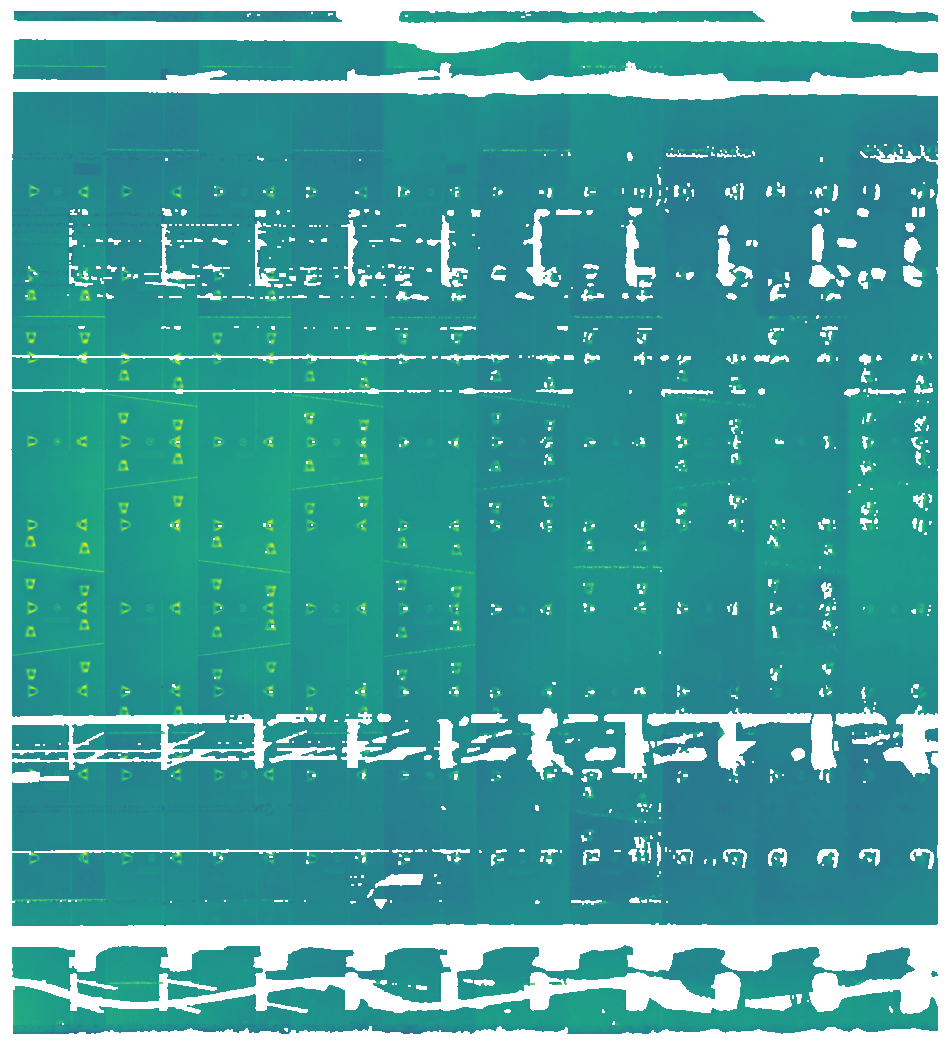

In [33]:
import matplotlib.pyplot as plt
# visualization
plt.figure(figsize=(12, 24))
plt.imshow(depth_map, cmap='viridis', vmin=2.70, vmax=2.80)
plt.axis('off')
plt.show()

In [34]:
import matplotlib.pyplot as plt

def save_depth_map_exact(depth_map, resolution, filename="depth_map.png"):
    """
    Save the depth map as an image with the exact dimensions and resolution.

    Parameters:
    depth_map: numpy array, the depth map to be saved.
    resolution: Float, the resolution used to generate the depth map (e.g., 0.005).
    filename: String, the filename to save the image as.
    """
    height, width = depth_map.shape
    dpi = 1.0 / resolution  # Calculate DPI from the resolution

    # Create a figure without any padding or axes
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])  # Add an axes covering the entire figure
    ax.axis('off')  # No axes for this plot
    
    # Display the depth map
    ax.imshow(depth_map, cmap='viridis', vmin=2.70, vmax=2.80)

    # Save the depth map with exact dimensions
    plt.savefig(filename, dpi=dpi, bbox_inches='tight', pad_inches=0)
    plt.close()


In [35]:
save_depth_map_exact(depth_map, resolution=0.005, filename="depth_map.png")

# Algorithm 4: Prompt point generation 

##  1. Obtain initial prompt points

In [36]:
data_joint_2 = {
    'x': df_enhance_joint['h'],
    'y': df_enhance_joint['theta'],
    'z': df_enhance_joint['r'],
    'pred': df_enhance_joint['pred'],
    'intensity': df_enhance_joint['intensity'],
}

df_joint = pd.DataFrame(data_joint_2)

# df_joint = df_joint[df_joint['intensity'] <= -1200]

In [37]:
# generate map only including outlier point
depth_map_outlier,_ = project_to_depth_map_inter(data_segment, df_joint, window_size=1, outlier_mode=True)

L 2663 W 2413


Processing point clouds:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
# pre-processing

import cv2

binary_map = np.where(np.isnan(depth_map_outlier), 0, 255).astype(np.uint8)

ret, binary_image = cv2.threshold(binary_map, 127, 255, cv2.THRESH_BINARY)  #100

kernel = np.ones((3, 3), np.uint8)

dilated_edges = cv2.dilate(binary_image, kernel, iterations=1)  #1

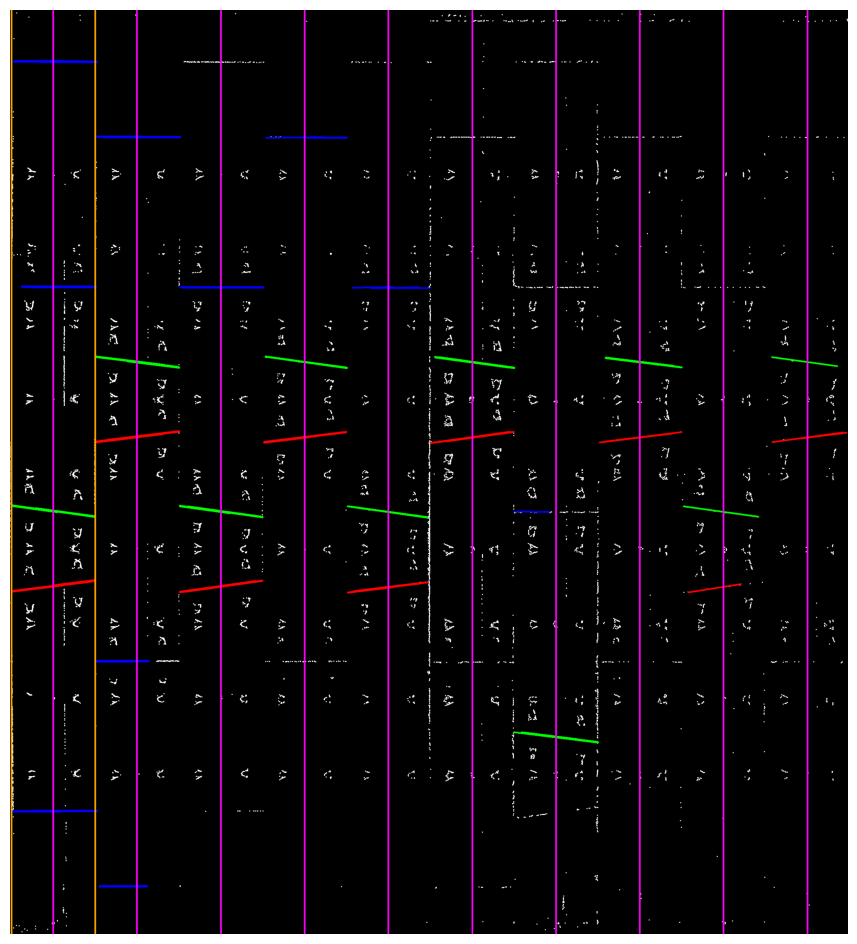

In [40]:
# detection

import cv2
import numpy as np
import matplotlib.pyplot as plt

# L, W = cropped_map.shape
L, W = binary_map.shape

# Oblique line segment detection parameters
lines_oblique = cv2.HoughLinesP(dilated_edges, 1, np.pi / 180, 50, minLineLength=100, maxLineGap=40)  # Width 240/cos(7.5°)=242

# Horizontal line detection parameters (0 degrees)
lines_horizontal = cv2.HoughLinesP(dilated_edges, 1, np.pi / 180, 50, minLineLength=100, maxLineGap=10)  # Width 240

# Vertical line detection (using cv2.HoughLines, for the whole station, 
# the detection range needs to be adjusted, sample here is around half of a station)
lines_vertical = cv2.HoughLines(dilated_edges, 1, np.pi / 180, 500)
lines_vertical = lines_vertical[lines_vertical[:, 0, 0] <= (5 * 1200 / (resolution*1000))]

# Prepare output image
output_image = cv2.cvtColor(dilated_edges, cv2.COLOR_GRAY2BGR)

# Define colors
color_angle1 = (255, 0, 0)  # Red for positive angle lines
color_angle2 = (0, 255, 0)  # Green for negative angle lines
color_horizontal = (0, 0, 255)  # Blue for horizontal lines
color_vertical = (255, 165, 0)  # Orange for vertical lines
color_mid_lines = (255, 0, 255)  # Magenta for centered lines
line_thickness = 3  # Line thickness

# Detect and draw oblique lines with angles between 6-9 degrees and -9 to -6 degrees
joint_oblique_positive = []
joint_oblique_negtive = []
joint_horizontal = []
if lines_oblique is not None:
    for line in lines_oblique:
        x1, y1, x2, y2 = line[0]
        x1, x2, y1, y2 = (x2, x1, y2, y1) if x1 > x2 else (x1, x2, y1, y2)
        angle = np.degrees(np.arctan2(-(y2 - y1), x2 - x1))  # Invert y-coordinates to match standard angle direction (with y-axis up)

        if 6 <= angle <= 9:
            joint_oblique_positive.append(line)
            cv2.line(output_image, (x1, y1), (x2, y2), color_angle1, line_thickness)

        elif -9 <= angle <= -6:
            joint_oblique_negtive.append(line)
            cv2.line(output_image, (x1, y1), (x2, y2), color_angle2, line_thickness)

# Detect and draw horizontal lines
# Tips: in our case, considering the better robustness of oblique line segment detection, 
# we do not consider horizontal line segments, unless the no oblique line segment is recognized;
if lines_horizontal is not None:
    for line in lines_horizontal:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        # Near-horizontal line range
        if -1 <= angle <= 1:
            joint_horizontal.append(line)
            cv2.line(output_image, (x1, y1), (x2, y2), color_horizontal, line_thickness)

# Merge close vertical lines
merged_lines = []
all_mid_lines = []
threshold_distance = 3  # 3 pixels

if lines_vertical is not None:
    lines_vertical = lines_vertical[:, 0]  # Convert to 2D array

    # Iterate over all detected vertical lines
    for i, (rho1, theta1) in enumerate(lines_vertical):
        if -0.5 * np.pi / 180 <= abs(theta1) <= 0.5 * np.pi / 180:  # Ensure it is a vertical line
            x1, y1 = rho1 * np.cos(theta1), rho1 * np.sin(theta1)
            is_merged = False
            
            # Check if there is a close vertical line
            for j, (rho2, theta2) in enumerate(merged_lines):
                x2, y2 = rho2 * np.cos(theta2), rho2 * np.sin(theta2)
                if np.sqrt((x1 - x2)**2 + (y1 - y2)**2) < threshold_distance:
                    # Merge lines
                    new_rho = (rho1 + rho2) / 2
                    new_theta = (theta1 + theta2) / 2
                    merged_lines[j] = (new_rho, new_theta)
                    is_merged = True
                    break
            
            if not is_merged:
                merged_lines.append((rho1, theta1))
                
    # Sort merged_lines by rho
    merged_lines.sort(key=lambda line: line[0])

    # Draw merged vertical lines
    for rho, theta in merged_lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 2677 * (-b))
        y1 = int(y0 + 2677 * (a))
        x2 = int(x0 - 2677 * (-b))
        y2 = int(y0 - 2677 * (a))
        cv2.line(output_image, (x1, y1), (x2, y2), color_vertical, line_thickness)

    # Calculate centered lines between adjacent vertical lines
    mid_lines = []
    num_lines = len(merged_lines)
    for i in range(num_lines - 1):
        rho1, theta1 = merged_lines[i]
        rho2, theta2 = merged_lines[i + 1]
        # Calculate midpoint
        new_rho = (rho1 + rho2) / 2
        new_theta = (theta1 + theta2) / 2
        mid_lines.append((new_rho, new_theta))
        
        # Draw centered lines
        a = np.cos(new_theta)
        b = np.sin(new_theta)
        x0 = a * new_rho
        y0 = b * new_rho
        x1 = int(x0 + L * (-b))
        y1 = int(y0 + L * (a))
        x2 = int(x0 - L * (-b))
        y2 = int(y0 - L * (a))
        cv2.line(output_image, (x1, y1), (x2, y2), color_mid_lines, line_thickness)

    # Calculate average distance between centered lines
    distances = []
    for i in range(len(mid_lines) - 1):
        rho1, theta1 = mid_lines[i]
        rho2, theta2 = mid_lines[i + 1]
        x1, y1 = rho1 * np.cos(theta1), rho1 * np.sin(theta1)
        x2, y2 = rho2 * np.cos(theta2), rho2 * np.sin(theta2)
        distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
        distances.append(distance)

    avg_distance_detected = np.mean(distances) if distances else 0
    
    avg_distance_designed = W/ring_count
    
    if np.abs(avg_distance_detected - (1.2 / resolution)) <= np.abs(avg_distance_designed - (1.2 / resolution)):
        avg_distance = avg_distance_detected
    else:
        avg_distance = avg_distance_designed

    # Save all centered lines records
    all_mid_lines = mid_lines.copy()

    # Starting from the leftmost centered line, draw new centered lines at the average distance
    if mid_lines:
        # Leftmost centered line
        leftmost_rho, leftmost_theta = mid_lines[0]
        a = np.cos(leftmost_theta)
        b = np.sin(leftmost_theta)
        x0 = a * leftmost_rho
        y0 = b * leftmost_rho
    
        # Draw centered lines to the left
        while x0 >= 0:
            x1 = int(x0 + L * (-b))
            y1 = int(y0 + L * (a))
            x2 = int(x0 - L * (-b))
            y2 = int(y0 - L * (a))
            cv2.line(output_image, (x1, y1), (x2, y2), color_mid_lines, line_thickness)
            all_mid_lines.append((x0, leftmost_theta))  # Save new centered line record
            x0 -= avg_distance
    
        # Rightmost centered line
        rightmost_rho, rightmost_theta = mid_lines[-1]
        a = np.cos(rightmost_theta)
        b = np.sin(rightmost_theta)
        x0 = a * rightmost_rho
        y0 = b * rightmost_rho
    
        # Draw centered lines to the right
        while x0 <= output_image.shape[1]:
            x1 = int(x0 + L * (-b))
            y1 = int(y0 + L * (a))
            x2 = int(x0 - L * (-b))
            y2 = int(y0 - L * (a))
            cv2.line(output_image, (x1, y1), (x2, y2), color_mid_lines, line_thickness)
            all_mid_lines.append((x0, rightmost_theta))  # Save new centered line record
            x0 += avg_distance

all_mid_lines = sorted(list(set(all_mid_lines)), key=lambda line: line[0])

# Display the result
plt.figure(figsize=(12, 12))
plt.imshow(output_image)
# plt.title('Detected Lines')
plt.axis('off')
plt.show()


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def line_segment_vertical_intersection(vertical_x, segment):
    """Compute the intersection of a vertical line x = vertical_x with a line segment."""
    x1, y1, x2, y2 = segment
    
    if x1 == x2:
        return None
    
    if min(x1, x2) <= vertical_x <= max(x1, x2):
        t = (vertical_x - x1) / (x2 - x1)
        intersect_y = y1 + t * (y2 - y1)
        return (vertical_x, intersect_y)
    return None

def merge_close_points(points, threshold=6):
    """Merge points that are within a certain distance of each other."""
    points = np.array(points)
    if len(points) == 0:
        return np.array([])
    if len(points) == 1:
        return points
    merged_points = []
    while len(points) > 0:
        p = points[0]
        close_points = np.linalg.norm(points - p, axis=1) < threshold
        merged_points.append(np.mean(points[close_points], axis=0))
        points = points[~close_points]
    return np.array(merged_points)

def compute_midpoint(p1, p2):
    """Compute the midpoint of two points."""
    return ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)

def check_distance_pattern(points, k, ab, tolerance=10):
    """Check if the distances between points follow the pattern a+nb, n=2,4,5 within a tolerance."""
    points = sorted(points, key=lambda p: p[0])
    for i in range(len(points) - 1):
        for j in range(i + 1, len(points)):
            distance = np.linalg.norm(np.array(points[i]) - np.array(points[j]))
            if any(abs(distance - (k + m * ab)) < tolerance for m in [2, 4]):
                return compute_midpoint(points[i], points[j])
    return None

# Input data (assuming these are defined elsewhere)
vertical_lines = all_mid_lines
horizontal_lines = joint_horizontal
positive_slope_lines = joint_oblique_positive
negative_slope_lines = joint_oblique_negtive

# Variables to hold results
adjusted_points = []

# Preset values for distance pattern checking
K_height_pixel = 1079.92 / (1000*resolution)
AB_height_pixel = 3239.77 / (1000*resolution)

# Detect intersections
for vertical_x, _ in vertical_lines:
    intersections_with_positive_slope = []
    intersections_with_negative_slope = []
    intersections_with_horizontal = []
    
    # Check intersections with positive slope lines
    for segment in positive_slope_lines:
        inter_point = line_segment_vertical_intersection(vertical_x, segment[0])
        if inter_point:
            intersections_with_positive_slope.append(inter_point)
    
    # Check intersections with negative slope lines
    for segment in negative_slope_lines:
        inter_point = line_segment_vertical_intersection(vertical_x, segment[0])
        if inter_point:
            intersections_with_negative_slope.append(inter_point)
    
    merge_positive = merge_close_points(intersections_with_positive_slope)
    merge_negative = merge_close_points(intersections_with_negative_slope)
    
    # Case 1: Intersecting two different types of slope lines
    if len(merge_positive) > 0 and len(merge_negative) > 0:
        midpoint = compute_midpoint(merge_positive[0], merge_negative[0])
        adjusted_points.append(('midpoint', midpoint))
    
    # Case 2: Only positive slope intersections
    elif len(merge_positive) > 0:
        point = merge_positive[0]
        adjusted_points.append(('positive_slope', (point[0], point[1] - 0.5*K_height_pixel)))
    
    # Case 3: Only negative slope intersections
    elif len(merge_negative) > 0:
        point = merge_negative[0]
        adjusted_points.append(('negative_slope', (point[0], point[1] + 0.5*K_height_pixel)))
    
    # Case 4: Check intersections with horizontal lines if no oblique segments were detected
    else:
        for segment in horizontal_lines:
            inter_point = line_segment_vertical_intersection(vertical_x, segment[0])
            if inter_point:
                intersections_with_horizontal.append(inter_point)
        merge_horizontal = merge_close_points(intersections_with_horizontal)

        # Check for distance pattern in horizontal intersections
        pattern_midpoint = check_distance_pattern(merge_horizontal, K_height_pixel, AB_height_pixel, tolerance=50)
        if pattern_midpoint:
            adjusted_points.append(('horizontal', pattern_midpoint))
        else:
            # Determine the y-coordinate of the assumed point based on the previous point
            if adjusted_points:
                last_point_y = adjusted_points[-1][1][1]  # Get the y-value of the last added point
                if 1035 <= last_point_y <= 1265:  # Approximately 1150 +/- 10%
                    assumed_y = last_point_y + 431.87
                elif 1422 <= last_point_y <= 1738:  # Approximately 1580 +/- 10%
                    assumed_y = last_point_y - 431.87
                else:
                    # Check one point further back if last point is not in range
                    if len(adjusted_points) > 1:
                        second_last_point_y = adjusted_points[-2][1][1]
                        if 1035 <= second_last_point_y <= 1265:
                            assumed_y = second_last_point_y
                        elif 1422 <= second_last_point_y <= 1738:
                            assumed_y = second_last_point_y
                        else:
                            assumed_y = None  # Default or fallback logic if needed
                    else:
                        assumed_y = None  # Default or fallback logic if needed
            else:
                assumed_y = None  # Default or fallback logic if needed

            if assumed_y is not None:
                adjusted_points.append(('assume', (vertical_x, assumed_y)))
            else:
                # If no assumption can be made, you might decide on a default or skip
                # For example:
                # adjusted_points.append(('assume', (vertical_x, some_default_y_value)))
                raise ValueError(f"Unable to find starting point for vertical line at x = {vertical_x}")

# recording initial point coordinate
df_loc = pd.DataFrame(adjusted_points, columns=['Type', 'Coordinates'])
df_loc['X'] = df_loc['Coordinates'].apply(lambda coord: coord[0])
df_loc['Y'] = df_loc['Coordinates'].apply(lambda coord: coord[1])
df_loc = df_loc.drop(columns=['Coordinates'])
df_loc = df_loc.sort_values(by='X').reset_index(drop=True)

print(f"Number of vertical lines: {len(vertical_lines)}")
print(f"Number of adjusted points: {len(adjusted_points)}")
print("DataFrame:")
print(df_loc)

Number of vertical lines: 10
Number of adjusted points: 10
DataFrame:
             Type       X            Y
0        midpoint   124.5  1551.909809
1        midpoint   365.8  1121.683901
2        midpoint   607.1  1552.750057
3        midpoint   848.4  1122.593396
4        midpoint  1089.7  1554.781168
5        midpoint  1331.0  1122.937290
6  negative_slope  1572.3  2202.663607
7        midpoint  1813.6  1122.722749
8        midpoint  2054.9  1554.003874
9        midpoint  2296.2  1122.829426


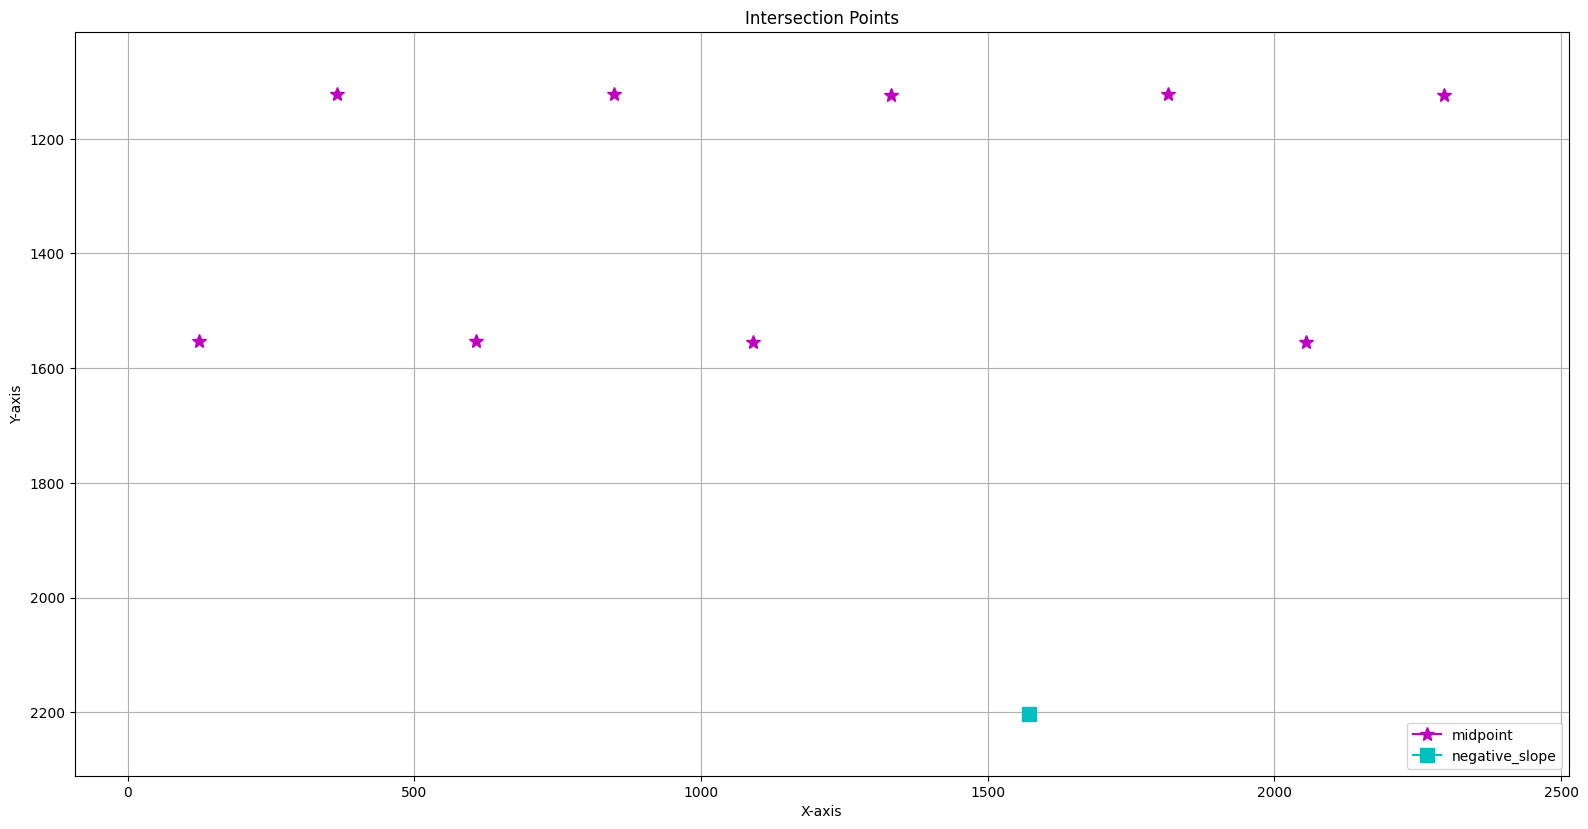

In [42]:
# if you want to visualize
plt.figure(figsize=(16, 16))
ax = plt.gca()

colors = {'horizontal': 'b', 'positive_slope': 'r', 'negative_slope': 'c', 'midpoint': 'm', 'assume':'g'}
markers = {'horizontal': 'o', 'positive_slope': '^', 'negative_slope': 's', 'midpoint': '*','assume':'d'}

for label, (x, y) in adjusted_points:
    ax.plot(x, y, color=colors[label], marker=markers[label], markersize=10, label=label)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower right')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Intersection Points')
ax.set_aspect('equal', adjustable='box')
ax.invert_yaxis()

x_min, x_max = df_loc['X'].min(), df_loc['X'].max()
y_min, y_max = df_loc['Y'].min(), df_loc['Y'].max()
margin = 0.1
x_range = x_max - x_min
y_range = y_max - y_min
ax.set_xlim(x_min - margin * x_range, x_max + margin * x_range)
ax.set_ylim(y_max + margin * y_range, y_min - margin * y_range) 

plt.grid(True)
plt.tight_layout()
plt.show()


In [43]:
df_loc.to_csv('initial_points.csv',index=False)

## 2. Template prompt point generatoin and mask obtain

In [44]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.path import Path
import cv2
import math
from tqdm import tqdm
import pickle

import sys
sys.path.append("../../segment-anything-main") # you should prepare SAM before you use the next step
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide

In [45]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [46]:
sam_checkpoint = "../../segment-anything-main/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

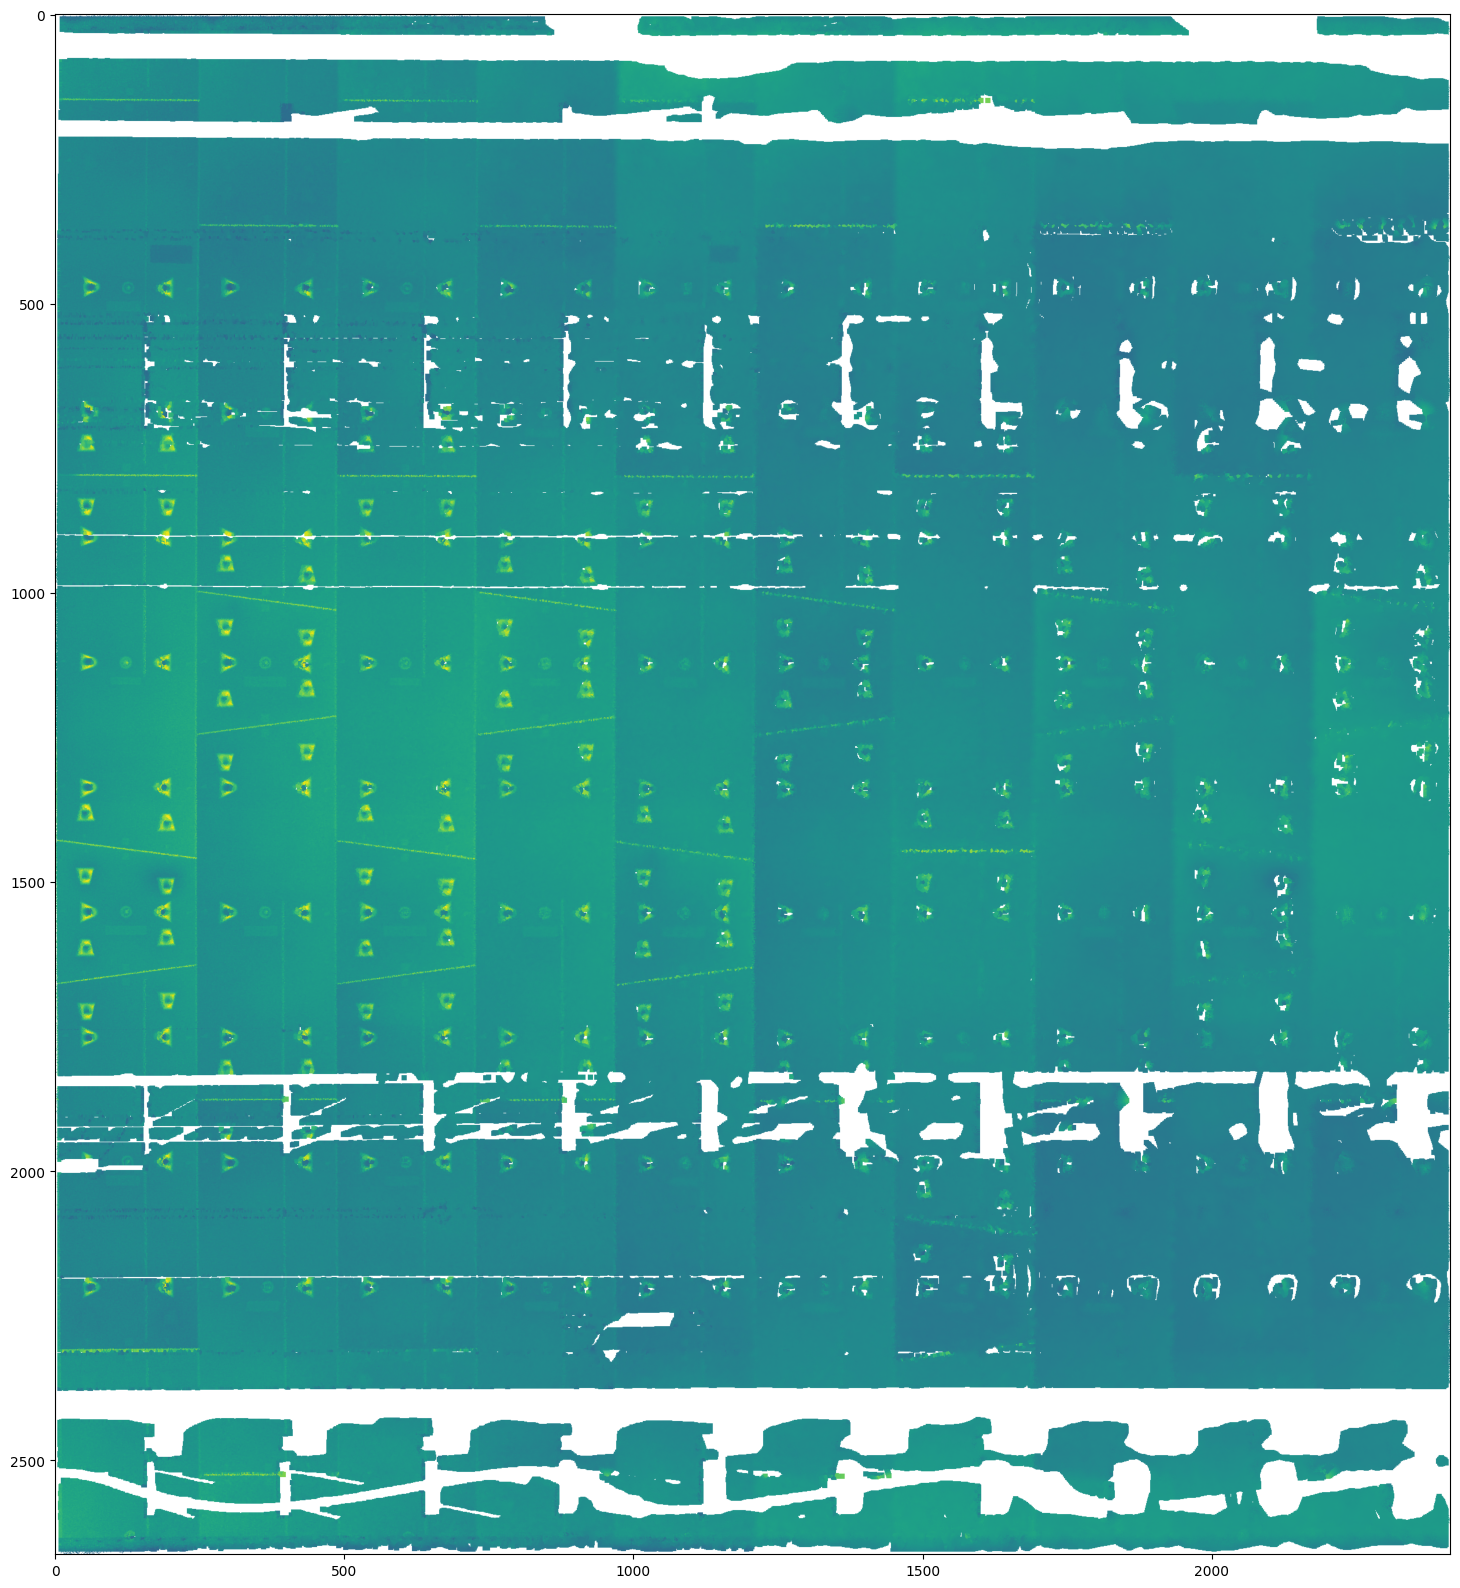

In [48]:
# read projection map, here you also can change the channel combination of input image
image = cv2.imread('depth_map.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('on')
plt.show()

In [49]:
# template prompt generation, including coarse mask and point
def fill_polygon(mask, vertices):

    path = Path(vertices)
    
    y_coords, x_coords = np.mgrid[:mask.shape[0], :mask.shape[1]]
    points = np.vstack((x_coords.flatten(), y_coords.flatten())).T
    mask_inside = path.contains_points(points).reshape(mask.shape)

    mask[mask_inside] = 1
             
def generate_template_mask(height, width, prompt_centre, block, resolution=0.005):
    mask = np.zeros((height, width), dtype=np.uint8)

    prompt_centre_x, prompt_centre_y = prompt_centre
    x = prompt_centre_x * (resolution*1000)
    y = prompt_centre_y * (resolution*1000)
    
    if block == 'K':
        vertices_real = np.array([[x-625,y-619.16],[x-625,y+619.16],[x+625,y+460.77],[x+625,y-460.77]])
    elif block == 'B1':
        vertices_real = np.array([[x-625,y-1619.89],[x-625,y+1540.69],[x+625,y+1699.08],[x+625,y-1619.89]])
    elif block == 'B2':
        vertices_real = np.array([[x-625,y-1540.69],[x-625,y+1619.89],[x+625,y+1619.89],[x+625,y-1699.08]])
    else:
        vertices_real = np.array([[x-625,y-1619.89],[x-625,y+1619.89],[x+625,y+1619.89],[x+625,y-1619.89]])
        
    vertices = vertices_real / (resolution*1000)
        
    fill_polygon(mask, vertices)
    return mask

def generate_prompt_points(prompt_centre, initial_x, map_y, block, resolution=0.005,
                           segment_width=1200, K_height=1079.92, AB_height=3239.77):
    """
    prompt_centre is prompt centre of this sub-image, pixel coordinate
    (initial_x, map_y) pixel coordinate of prompt centre in orignal depth map
    block is type of block of segment
    resolution is pixel/real ratio
    other parameters are design params
    """
    prompt_centre_x, prompt_centre_y = prompt_centre
    x = prompt_centre_x * (resolution*1000)
    y = prompt_centre_y * (resolution*1000)
    map_y = map_y * (resolution*1000)
    
    if block == 'K':
        points_real = np.array([
            [x-700,y-732.35],[x-700,y-505.96],[x-700,y-310.91],[x-700,y],[x-700,y+310.91],[x-700,y+505.96],[x-700,y+732.35],
            [x-500,y-705.96],[x-500,y+705.96],
            [x-348.16,y-685.91],[x-348.16,y-310.91],[x-325,y],[x-348.16,y+310.91],[x-348.16,y+685.91],
            [x,y-639.96],[x,y],[x,y+639.96],
            [x+348.16,y-594.01],[x+348.16,y-219.01],[x+325,y],[x+348.16,y+219.01],[x+348.16,y+594.01],
            [x+500,y-573.96],[x+500,y+573.96],
            [x+700,y-547.57],[x+700,y-373.96],[x+700,y-219.01],[x+700,y],[x+700,y+219.01],[x+700,y+373.96],[x+700,y+547.57],  # above are negative

            [x-500,y-505.96],[x-511.06,y-310.91],[x-500,y],[x-511.06,y+310.91],[x-500,y+505.96],
            [x-348.16,y-485.91],[x-348.16,y+485.91],
            [x,y-439.96],[x,y+439.96],
            [x+348.16,y-394.01],[x+348.16,y+394.01],
            [x+500,y-373.96],[x+511.06,y-219.01],[x+500,y],[x+511.06,y+219.01],[x+500,y+373.96]
        ])
        labels = np.repeat([0, 1], [31, 16])

    elif block == 'B1':
        points_real = np.array([
            [x-700,y-1719.89],[x-511.06,y-1719.89],[x-348.16,y-1719.89],[x,y-1719.89],[x+348.16,y-1719.89],[x+511.06,y-1719.89],[x+700,y-1719.89],
            [x-700,y-1519.89],[x+700,y-1519.89],
            [x-700,y-1344.89],[x-348.16,y-1344.89],[x+348.16,y-1344.89],[x+700,y-1344.89],
            [x-700,y-1090.09],[x-325,y-1090.09],[x+325,y-1090.09],[x+700,y-1090.09],
            [x-700,y-817.57],[x+700,y-817.57],
            [x-700,y-545.05],[x+700,y-545.05],
            [x-700,y-272.52],[x+700,y-272.52],
            [x-700,y],[x-325,y],[x,y],[x+325,y],[x+700,y],
            [x-700,y+272.52],[x+700,y+272.52],
            [x-700,y+545.05],[x+700,y+545.05],
            [x-700,y+817.57],[x+700,y+817.57],
            [x-700,y+1090.09],[x-325,y+1090.09],[x+325,y+1090.09],[x+700,y+1090.09],
            [x-700,y+1298.93],[x-350,y+1298.93],[x+350,y+1390.84],[x+700,y+1390.84],
            [x-700,y+1427.43],[x+700,y+1612.28],
            [x-700,y+1627.49],[x-511.06,y+1652.43],[x-350,y+1673.69],[x,y+1719.89],[x+350,y+1766.08],[x+511.06,y+1787.34],[x+700,y+1812.28],

            [x-511.06,y-1519.89],[x-348.16,y-1519.89],[x,y-1519.89],[x+348.16,y-1519.89],[x+511.06,y-1519.89],
            [x-511.06,y-1344.89],[x,y-1344.89],[x+511.06,y-1344.89],
            [x-500,y-1090.09],[x,y-1090.09],[x+500,y-1090.09],
            [x-500,y-817.57],[x-250,y-817.57],[x,y-817.57],[x+250,y-817.57],[x+500,y-817.57],
            [x-500,y-545.05],[x-250,y-545.05],[x,y-545.05],[x+250,y-545.05],[x+500,y-545.05],
            [x-500,y-272.52],[x-250,y-272.52],[x,y-272.52],[x+250,y-272.52],[x+500,y-272.52],
            [x-500,y],[x-162.5,y],[x+162.5,y],[x+500,y],
            [x-500,y+272.52],[x-250,y+272.52],[x,y+272.52],[x+250,y+272.52],[x+500,y+272.52],
            [x-500,y+545.05],[x-250,y+545.05],[x,y+545.05],[x+250,y+545.05],[x+500,y+545.05],
            [x-500,y+817.57],[x-250,y+817.57],[x,y+817.57],[x+250,y+817.57],[x+500,y+817.57],
            [x-500,y+1090.09],[x,y+1090.09],[x+500,y+1090.09],
            [x-511.06,y+1298.93],[x,y+1345.01],[x+511.06,y+1390.84],
            [x-511.06,y+1452.43],[x-350,y+1473.69],[x,y+1519.89],[x+350,y+1566.08],[x+511.06,y+1587.34]      
        ])
        labels = np.repeat([0,1],[51,56])

    elif block == 'B2':
        points_real = np.array([
            [x-700,y-1627.49],[x-511.06,y-1652.43],[x-350,y-1673.69],[x,y-1719.89],[x+350,y-1766.08],[x+511.06,y-1787.34],[x+700,y-1812.28],
            [x-700,y-1427.43],[x+700,y-1612.28],
            [x-700,y-1298.93],[x-350,y-1298.93],[x+350,y-1390.84],[x+700,y-1390.84],            
            [x-700,y-1090.09],[x-325,y-1090.09],[x+325,y-1090.09],[x+700,y-1090.09],
            [x-700,y-817.57],[x+700,y-817.57],
            [x-700,y-545.05],[x+700,y-545.05],
            [x-700,y-272.52],[x+700,y-272.52],
            [x-700,y],[x-325,y],[x,y],[x+325,y],[x+700,y],
            [x-700,y+272.52],[x+700,y+272.52],
            [x-700,y+545.05],[x+700,y+545.05],
            [x-700,y+817.57],[x+700,y+817.57],
            [x-700,y+1090.09],[x-325,y+1090.09],[x+325,y+1090.09],[x+700,y+1090.09],
            [x-700,y+1344.89],[x-348.16,y+1344.89],[x+348.16,y+1344.89],[x+700,y+1344.89],
            [x-700,y+1519.89],[x+700,y+1519.89],
            [x-700,y+1719.89],[x-511.06,y+1719.89],[x-348.16,y+1719.89],[x,y+1719.89],[x+348.16,y+1719.89],[x+511.06,y+1719.89],[x+700,y+1719.89],

            [x-511.06,y-1452.43],[x-350,y-1473.69],[x,y-1519.89],[x+350,y-1566.08],[x+511.06,y-1587.34],     
            [x-511.06,y-1298.93],[x,y-1345.01],[x+511.06,y-1390.84],
            [x-500,y-1090.09],[x,y-1090.09],[x+500,y-1090.09],
            [x-500,y-817.57],[x-250,y-817.57],[x,y-817.57],[x+250,y-817.57],[x+500,y-817.57],
            [x-500,y-545.05],[x-250,y-545.05],[x,y-545.05],[x+250,y-545.05],[x+500,y-545.05],
            [x-500,y-272.52],[x-250,y-272.52],[x,y-272.52],[x+250,y-272.52],[x+500,y-272.52],
            [x-500,y],[x-162.5,y],[x+162.5,y],[x+500,y],
            [x-500,y+272.52],[x-250,y+272.52],[x,y+272.52],[x+250,y+272.52],[x+500,y+272.52],
            [x-500,y+545.05],[x-250,y+545.05],[x,y+545.05],[x+250,y+545.05],[x+500,y+545.05],
            [x-500,y+817.57],[x-250,y+817.57],[x,y+817.57],[x+250,y+817.57],[x+500,y+817.57],
            [x-500,y+1090.09],[x,y+1090.09],[x+500,y+1090.09],
            [x-511.06,y+1344.89],[x,y+1344.89],[x+511.06,y+1344.89],
            [x-511.06,y+1519.89],[x-348.16,y+1519.89],[x,y+1519.89],[x+348.16,y+1519.89],[x+511.06,y+1519.89],
        ])
        labels = np.repeat([0,1],[51,56])
            
    else:
        points_real = np.array([
            [x-700,y-1719.89],[x-511.06,y-1719.89],[x-348.16,y-1719.89],[x,y-1719.89],[x+348.16,y-1719.89],[x+511.06,y-1719.89],[x+700,y-1719.89],
            [x-700,y-1519.89],[x+700,y-1519.89],
            [x-700,y-1344.89],[x-348.16,y-1344.89],[x+348.16,y-1344.89],[x+700,y-1344.89],
            [x-700,y-1090.09],[x-325,y-1090.09],[x+325,y-1090.09],[x+700,y-1090.09],
            [x-700,y-817.57],[x+700,y-817.57],
            [x-700,y-545.05],[x+700,y-545.05],
            [x-700,y-272.52],[x+700,y-272.52],
            [x-700,y],[x-325,y],[x,y],[x+325,y],[x+700,y],
            [x-700,y+272.52],[x+700,y+272.52],
            [x-700,y+545.05],[x+700,y+545.05],
            [x-700,y+817.57],[x+700,y+817.57],
            [x-700,y+1090.09],[x-325,y+1090.09],[x+325,y+1090.09],[x+700,y+1090.09],
            [x-700,y+1344.89],[x-348.16,y+1344.89],[x+348.16,y+1344.89],[x+700,y+1344.89],
            [x-700,y+1519.89],[x+700,y+1519.89],
            [x-700,y+1719.89],[x-511.06,y+1719.89],[x-348.16,y+1719.89],[x,y+1719.89],[x+348.16,y+1719.89],[x+511.06,y+1719.89],[x+700,y+1719.89],

            [x-511.06,y-1519.89],[x-348.16,y-1519.89],[x,y-1519.89],[x+348.16,y-1519.89],[x+511.06,y-1519.89],
            [x-511.06,y-1344.89],[x,y-1344.89],[x+511.06,y-1344.89],
            [x-500,y-1090.09],[x,y-1090.09],[x+500,y-1090.09],
            [x-500,y-817.57],[x-250,y-817.57],[x,y-817.57],[x+250,y-817.57],[x+500,y-817.57],
            [x-500,y-545.05],[x-250,y-545.05],[x,y-545.05],[x+250,y-545.05],[x+500,y-545.05],
            [x-500,y-272.52],[x-250,y-272.52],[x,y-272.52],[x+250,y-272.52],[x+500,y-272.52],
            [x-500,y],[x-162.5,y],[x+162.5,y],[x+500,y],
            [x-500,y+272.52],[x-250,y+272.52],[x,y+272.52],[x+250,y+272.52],[x+500,y+272.52],
            [x-500,y+545.05],[x-250,y+545.05],[x,y+545.05],[x+250,y+545.05],[x+500,y+545.05],
            [x-500,y+817.57],[x-250,y+817.57],[x,y+817.57],[x+250,y+817.57],[x+500,y+817.57],
            [x-500,y+1090.09],[x,y+1090.09],[x+500,y+1090.09],
            [x-511.06,y+1344.89],[x,y+1344.89],[x+511.06,y+1344.89],
            [x-511.06,y+1519.89],[x-348.16,y+1519.89],[x,y+1519.89],[x+348.16,y+1519.89],[x+511.06,y+1519.89],
        ])
        labels = np.repeat([0,1],[51,56])

    # adjust y based on map_y, the bolt holes within this range are sealed.
    # for i in range(len(labels)):
    #     if labels[i] == 0:
    #         y_cond = points_real[i, 1] + map_y < 4100 or points_real[i, 1] + map_y > 13000
    #         x_cond = abs(points_real[i, 0] - x) <= segment_width*0.5
    #         y_limit = K_height if block == 'K' else AB_height
    #         y_cond2 = abs(points_real[i, 1] - y) <= y_limit*0.5
            
    #         if y_cond and x_cond and y_cond2:
    #             labels[i] = 1

    keep_mask = np.ones(len(labels), dtype=bool)
    for i in range(len(labels)):
        if labels[i] == 0:
            y_cond = points_real[i, 1] + map_y < 4200 or points_real[i, 1] + map_y > 13100
            x_cond = abs(points_real[i, 0] - x) <= segment_width * 0.5
            y_limit = K_height if block == 'K' else AB_height
            y_cond2 = abs(points_real[i, 1] - y) <= y_limit * 0.5
            
            if y_cond and x_cond and y_cond2:
                keep_mask[i] = False
            
    points_real = points_real[keep_mask]
    labels = labels[keep_mask]
    
    points = points_real / (resolution*1000)

    # outside the image x direction
    within_bounds = (points[:, 0] >= 0) & ((points[:, 0] + initial_x - (segment_width*0.5+150)/(resolution*1000)) <= image.shape[1])
    points = points[within_bounds]
    labels = labels[within_bounds]
        
    return points, labels

In [50]:
# define all auxiliary functions
def convert_to_pixel_coords(real_dist, resolution=0.005):
    return int(real_dist / (resolution*1000))

def crop_image_and_mask_logits(image, cx, cy, crop_width, crop_height, block, resolution):
    img_height, img_width, _ = image.shape

    # crop box calculation
    x1 = max(cx - crop_width // 2, 0)
    y1 = max(cy - crop_height // 2, 0)
    x2 = min(cx + crop_width // 2, img_width)
    y2 = min(cy + crop_height // 2, img_height)

    cropped_image = image[int(y1):int(y2), int(x1):int(x2)]
    
    # prompt centre of this sub-image, pixel coordinate
    prompt_centre_x = cx - x1
    prompt_centre_y = cy - y1
    prompt_centre = (prompt_centre_x,prompt_centre_y)
    
    cropped_template_mask = generate_template_mask(cropped_image.shape[0],cropped_image.shape[1],prompt_centre,block,resolution)
    template_mask_logits = compute_logits_from_mask(cropped_template_mask)

    return cropped_image, template_mask_logits, prompt_centre

def compute_logits_from_mask(mask, eps=1e-3):

    def inv_sigmoid(x):
        return np.log(x / (1 - x))

    logits = np.zeros(mask.shape, dtype="float32")
    logits[mask == 1] = 1 - eps
    logits[mask == 0] = eps
    logits = inv_sigmoid(logits)

    # resize to the expected mask shape of SAM (256x256)
    assert logits.ndim == 2
    expected_shape = (256, 256)

    if logits.shape == expected_shape:  # shape matches, do nothing
        pass

    elif logits.shape[0] == logits.shape[1]:  # shape is square
        trafo = ResizeLongestSide(expected_shape[0])
        logits = trafo.apply_image(logits[..., None])

    else:  # shape is not square
        # resize the longest side to expected shape
        trafo = ResizeLongestSide(expected_shape[0])
        logits = trafo.apply_image(logits[..., None])

        # pad the other side
        h, w = logits.shape
        padh = expected_shape[0] - h
        padw = expected_shape[1] - w
        # IMPORTANT: need to pad with zero, otherwise SAM doesn't understand the padding
        pad_width = ((0, padh), (0, padw))
        logits = np.pad(logits, pad_width, mode="constant", constant_values=0)

    logits = logits[None]
    assert logits.shape == (1, 256, 256), f"{logits.shape}"
    return logits

def restore_sam_logits(logits, original_shape):
    """
    reproject logits to same size of mask
    
    params:
        logits: 256x256 logits
        original_shape: original mask shape (height, width)
    
    return:
        logits with same shape of mask
    """
    
    orig_h, orig_w = original_shape
    
    trafo = ResizeLongestSide(max(orig_h, orig_w))
    resized_logits = trafo.apply_image(logits[..., None])
    resized_logits = resized_logits.squeeze()
    
    resized_logits = resized_logits[:orig_h, :orig_w]
    
    return resized_logits

def compute_block_label(segment_per_ring):
    """
    obtain the block name
    """
    block_labels = ['K','B1']
    num_a_labels = segment_per_ring - 3
    block_labels += [f'A{i+1}' for i in range(num_a_labels)]
    block_labels += ['B2']
    
    return block_labels

def sam_prediction(cropped_image, points, labels, template_mask_logit):
    predictor.set_image(cropped_image)
            
    mask, score, logit = predictor.predict(
            point_coords=points,
            point_labels=labels,
            mask_input=template_mask_logit,
            multimask_output=False,
    )
        
    return mask, score, logit[0]

In [51]:
# define main processing functions
def process_row(df_row, image, resolution=0.005, segment_per_ring=6, segment_width=1200, 
                K_height=1079.92, angle=7.52, AB_height=3239.77):

    initial_x, initial_y = df_row['X'], df_row['Y']
    block_labels = compute_block_label(segment_per_ring)  # start from "K, B1, A1, A2, A3,..., B2" depends on number of segment per ring

    delta_x = convert_to_pixel_coords(0.5*segment_width + 150, resolution)
    delta_y = 0

    reverse = False
    stop = False
    map_y = 0
    block_label_index = 0

    results = []
    for i in range(segment_per_ring):
        if reverse == False:
            block = block_labels[block_label_index]
            if block_label_index == 0:
                delta_y = convert_to_pixel_coords(0.5*K_height + math.tan(math.radians(angle))*700+100 + 50, resolution) # K-block
                map_y = initial_y
            else:
                delta_y = convert_to_pixel_coords(0.5*AB_height + math.tan(math.radians(angle))*700+100 + 50, resolution) # other block
                if block_label_index == 1:
                    map_y = initial_y - convert_to_pixel_coords(0.5 * K_height + 0.5 * AB_height, resolution)
                else:
                    map_y = map_y - convert_to_pixel_coords(AB_height, resolution)

            cropped_image, template_mask_logit, prompt_centre = crop_image_and_mask_logits(
                image, initial_x, map_y,2 * delta_x, 2 * delta_y, block, resolution)
            points, labels = generate_prompt_points(prompt_centre, initial_x, map_y, block, resolution)
        
            # check if outside the image in y-direction
            if np.any(points[:, 1] < 0):
                within_bounds = (points[:, 1] >= 0)
                points = points[within_bounds]
                labels = labels[within_bounds]
                reverse = True
                
            mask, score, logit = sam_prediction(cropped_image, points, labels, template_mask_logit)
        
            results.append({
                'left_top': (initial_x-prompt_centre[0], map_y-prompt_centre[1]),
                'block': block,
                'cropped_image': cropped_image,
                'mask': mask,
                'points':points,
                'labels':labels,
                'score': score,
                'logit': logit
            })
            
            if reverse:
                block_label_index = -1
                continue

            block_label_index = block_label_index + 1
            
        if reverse:
            block = block_labels[block_label_index]
            if block_label_index == -1:
                map_y = initial_y + convert_to_pixel_coords(0.5 * K_height + 0.5 * AB_height, resolution)
            else:
                map_y = map_y + convert_to_pixel_coords(AB_height, resolution)

            cropped_image, template_mask_logit, prompt_centre = crop_image_and_mask_logits(image, initial_x, map_y, 
                                                                                            2 * delta_x, 2 * delta_y, block, resolution)
            points, labels = generate_prompt_points(prompt_centre, initial_x, map_y, block, resolution)

            # check if outside the image in y-direction
            if np.any((points[:, 1]+map_y-delta_y) > image.shape[0]):
                within_bounds = ((points[:, 1]+map_y-delta_y) <= image.shape[0])
                points = points[within_bounds]
                labels = labels[within_bounds]
                stop = True

            mask, score, logit = sam_prediction(cropped_image, points, labels, template_mask_logit)

            results.append({
                'left_top': (initial_x-prompt_centre[0], map_y-prompt_centre[1]),
                'block': block,
                'cropped_image': cropped_image,
                'mask': mask,
                'points':points,
                'labels':labels,
                'score': score,
                'logit': logit
            })

            if stop:
                break

            block_label_index = block_label_index - 1
             
    return results


In [52]:
# Define execution functions
def sam_segment(df, image, resolution=0.005, segment_per_ring=6):
    all_results = []
 
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        result = process_row(row, image, resolution, segment_per_ring)
        all_results.append(result)
    
    return all_results


In [53]:
results = sam_segment(df_loc, image)

Processing rows: 100%|██████████| 10/10 [00:41<00:00,  4.17s/it]


In [59]:
# for saving results
with open('results.pkl', 'wb') as file:
    pickle.dump(results, file)

In [5]:
# for loading results
with open('results.pkl', 'rb') as file:
    results = pickle.load(file)

K


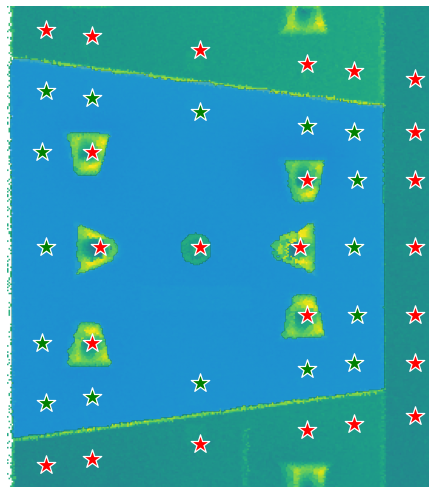

In [60]:
# if you want to check each instance

test_sample = results[0][0]
input_point = test_sample['points']
input_label = test_sample['labels']
cropped_image = test_sample['cropped_image']
masks = test_sample['mask']
logits = test_sample['logit']
print(test_sample['block'])
new_logits = restore_sam_logits(logits, masks.shape[1:])

height, width, _ = cropped_image.shape

display_dpi = 72
display_figsize = (width / display_dpi * 2, height / display_dpi * 2)

plt.figure(figsize=display_figsize, dpi=display_dpi)
plt.imshow(cropped_image)
# plt.imshow(new_logits)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## 3. Project back to point cloud

In [58]:
import numpy as np

# Define the mapping of block categories to labels
block_to_label = {'K': 1, 'B1': 2, 'A1': 3, 'A2': 4, 'A3': 5, 'B2': 6}  # 0 is reserved for uncovered areas

# Arrays to record the highest logits for each pixel and its corresponding label
logits_map = np.full(image.shape[:2], -np.inf, dtype=float)  # Initialize with very low values (since logits are typically unbounded)
label_map = np.zeros(image.shape[:2], dtype=int)  # Initialize to 0, representing uncovered areas
ring_map = np.zeros(image.shape[:2], dtype=int)  # Initialize to 0, representing uncovered areas

# Process results, merging sub-image masks back into the original depth map
for ring_index, ring in enumerate(results, start=0):  # Start ring numbering from 0
    for item in ring:
        mask = item['mask'][0]  # Mask
        logits = item['logit']  # Logits from the sub-image mask
        block = item['block']
        start_x, start_y = map(int, item['left_top'])  # Ensure coordinates are integers, note the order of x and y

        # Calculate the position of the sub-image in the original depth map
        end_y, end_x = start_y + mask.shape[0], start_x + mask.shape[1]
        
        # Ensure we don't go out of the original image boundaries
        start_y, start_x = max(0, start_y), max(0, start_x)
        end_y, end_x = min(image.shape[0], end_y), min(image.shape[1], end_x)
        
        # Calculate the valid range
        valid_slice_y = slice(start_y, end_y)
        valid_slice_x = slice(start_x, end_x)

        # Restore logits to match the mask shape
        new_logits = restore_sam_logits(logits, mask.shape)  # Restore logits to match mask size

        # Extract the corresponding region from the original logits_map
        current_logits = logits_map[valid_slice_y, valid_slice_x]

        # Now `mask` and `logits` should already be cropped at boundaries, so they should fit the valid region
        if mask.shape != current_logits.shape or new_logits.shape != current_logits.shape:
            raise ValueError(f"Shape mismatch after resizing: mask {mask.shape}, new_logits {new_logits.shape}, current_logits {current_logits.shape}")

        # Create an update mask based on logits comparison
        update_mask = (new_logits > current_logits) & mask
        
        # Update the logits map, label map, and ring map
        logits_map[valid_slice_y, valid_slice_x][update_mask] = new_logits[update_mask]
        label_map[valid_slice_y, valid_slice_x][update_mask] = block_to_label[block]
        ring_map[valid_slice_y, valid_slice_x][update_mask] = ring_index

# Assign label_map to result_image (semantic segmentation result)
result_image = label_map

# Assign ring_map to ring_image (instance segmentation result)
ring_image = ring_map


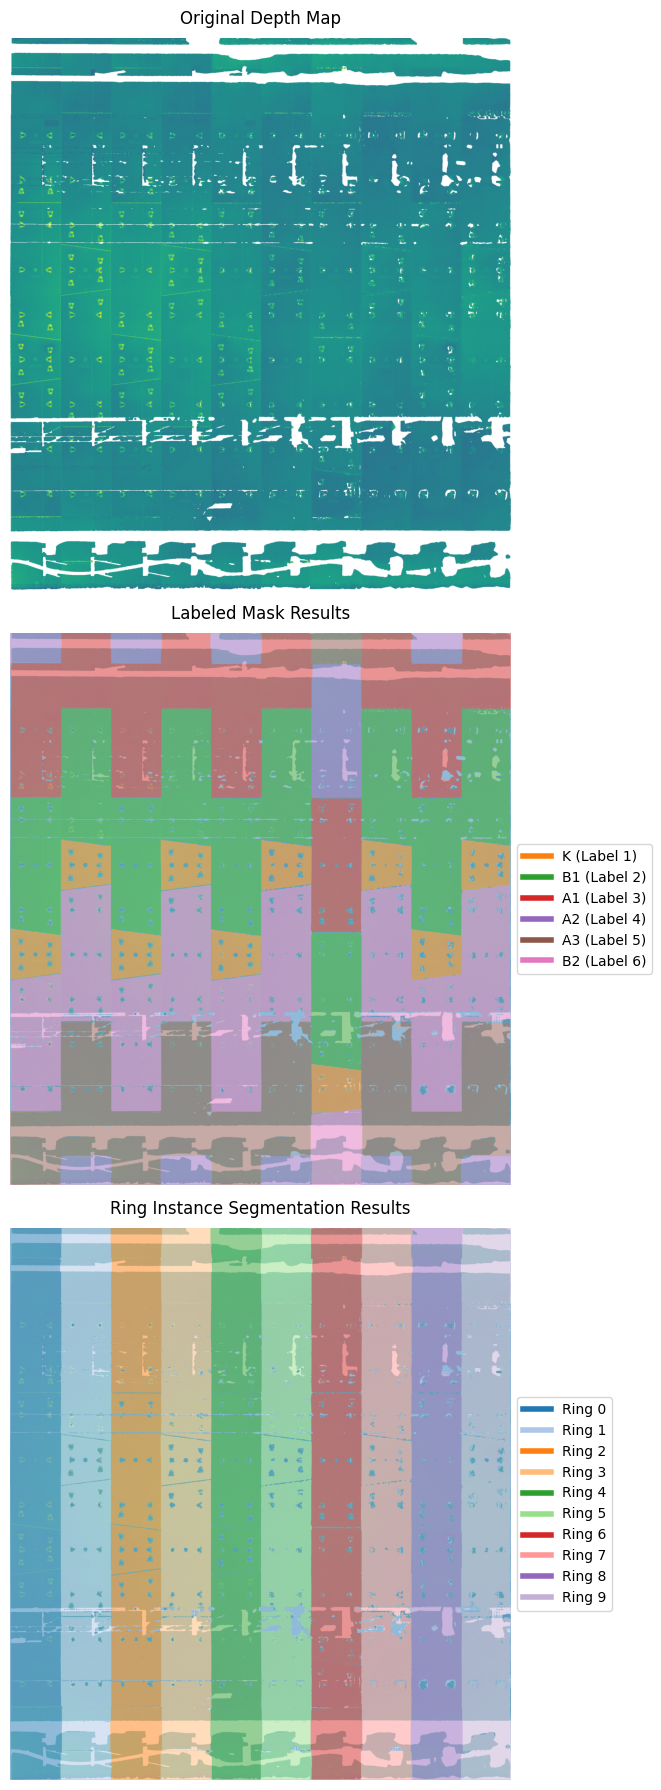

In [67]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_combined_results(image, result_image, ring_image):
    # Use new method to get color maps
    cmap_result = plt.colormaps['tab10']  # Use 'tab10' color map, you can choose others like 'Set1', 'Set2', 'Set3', etc.
    cmap_ring = plt.get_cmap('tab20')  # Use 'tab20' color map, which provides 20 different colors

    # Create RGB images for labeled and ring results
    colored_result = np.zeros((*result_image.shape, 3))
    colored_ring = np.zeros((*ring_image.shape, 3))
    
    # Assign colors to each label for result_image
    for label in range(7):  # 0-6, total of 7 labels
        mask = result_image == label
        colored_result[mask] = cmap_result(label)[:3]
    
    # Assign colors to each ring for ring_image
    unique_rings = np.unique(ring_image)
    for ring in unique_rings:
        mask = ring_image == ring
        color_index = ring % 20  # Cycle through 20 colors
        colored_ring[mask] = cmap_ring(color_index)[:3]
    
    # Create figure with three vertically stacked subplots, reduce height
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18), gridspec_kw={'height_ratios': [1, 1, 1]})
    
    # Reduce space between subplots
    plt.subplots_adjust(hspace=0.1)
    
    # Display original depth map
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Original Depth Map', pad=10)
    ax1.axis('off')
    
    # Display results with color labels
    ax2.imshow(image, cmap='gray', alpha=0.5)  # Show original depth map as background
    ax2.imshow(colored_result, alpha=0.5)  # Overlay color labels
    ax2.set_title('Labeled Mask Results', pad=10)
    ax2.axis('off')
    
    # Display ring instance segmentation results
    ax3.imshow(image, cmap='gray', alpha=0.5)  # Show original depth map as background
    ax3.imshow(colored_ring, alpha=0.5)  # Overlay color labels
    ax3.set_title('Ring Instance Segmentation Results', pad=10)
    ax3.axis('off')
    
    # Add color legend for labeled results
    legend_elements_result = [
        plt.Line2D([0], [0], color=cmap_result(label), lw=4, label=f'{block} (Label {label})')
        for label, block in {v: k for k, v in block_to_label.items()}.items()
    ]
    ax2.legend(handles=legend_elements_result, loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Add color legend for ring results
    legend_elements_ring = [
        plt.Line2D([0], [0], color=cmap_ring(ring % 20), lw=4, label=f'Ring {ring}')
        for ring in unique_rings
    ]
    ax3.legend(handles=legend_elements_ring, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_combined_results(image, result_image, ring_image)


In [61]:
# match rings's label if needed
fix_ring = np.where((ring_image >= 1) & (ring_image <= (ring_count-1)), ring_count - ring_image, ring_image)

In [62]:
import numpy as np
import pandas as pd

def project_back_to_point_cloud(segmented_map, instance_map, pixel_to_point, df):
    """
    Project the segmented depth map back to the point cloud.

    Parameters:
    segmented_map: Segmented depth map
    instance_map: Instance segmentation depth map
    pixel_to_point: Dict, mapping pixels to points
    df: Original point cloud data

    Returns:
    Updated point cloud DataFrame, including new segmentation labels.
    """

    # Create a copy of df to avoid modifying the original df
    df_copy = df.copy()

    # Initialize new label arrays
    pred = df_copy['pred'].values  # Keep the existing 'pred' values
    pred_ring = np.full(len(df_copy), -1, dtype=int)  # Initialize to -1

    # Get pixel coordinates and point cloud indices
    pixel_to_point_df = pd.DataFrame(pixel_to_point)
    y = pixel_to_point_df['pixel_y'].values
    x = pixel_to_point_df['pixel_x'].values
    point_indices = pixel_to_point_df['index'].values

    # Find indices of rows that need updating
    valid_point_mask = np.isin(point_indices, df_copy.index.values)

    # Update only rows where 'pred' value is 7
    valid_update_mask = (pred[point_indices[valid_point_mask]] == 7)

    # Use point_indices to index and update pred and pred_ring
    pred[point_indices[valid_point_mask][valid_update_mask]] = segmented_map[y[valid_point_mask][valid_update_mask], x[valid_point_mask][valid_update_mask]]
    pred_ring[point_indices[valid_point_mask][valid_update_mask]] = instance_map[y[valid_point_mask][valid_update_mask], x[valid_point_mask][valid_update_mask]]

    # Update df_copy
    df_copy['pred'] = pred
    df_copy['pred_ring'] = pred_ring

    return df_copy


In [63]:
updated_df = project_back_to_point_cloud(result_image, fix_ring, pixel_to_point, df_point_cloud)
updated_df.head()

x         y         z  intensity  segment  ring         r     theta  \
0 -2.511475 -4.519775 -1.281982    -1609.0        4     0  2.744104  2.125163   
1 -2.510010 -4.528076 -1.289307    -1591.0        4     0  2.747706  2.118148   
2 -2.502197 -4.524658 -1.292236    -1601.0        4     0  2.744669  2.110898   
3 -2.506592 -4.522217 -1.292725    -1637.0        4     0  2.748242  2.113945   
4 -2.507568 -4.512939 -1.291260    -1624.0        4     0  2.748568  2.116620   

           h  pred  pred_ring  
0  25.015549     3          9  
1  25.025597     3          9  
2  25.020573     3          9  
3  25.020573     3          9  
4  25.010525     4          0

In [44]:
updated_df.to_csv('final.csv',index=False)

In [66]:
df_pred = pd.DataFrame()
df_pred['gt_labels'] = updated_df['segment']
df_pred['gt_rings'] = updated_df['ring']
df_pred['pred_labels'] = updated_df['pred']
df_pred['pred_rings'] = updated_df['pred_ring']
df_pred.to_csv('only_label.csv',index=False)